Beginning portion of this notebook is from GMT to introduce PyGMT online: https://colab.research.google.com/github/GenericMappingTools/try-gmt/blob/master/landing-page.ipynb#scrollTo=d1hUuP_ZAOS2

**NOTE:** Any changes will be lost when the Jupyter lab is closed. Select "File"->"Download" to save notebooks to your computer.

To execute the code cells, select it and type `Shift + Enter` or click on the "Run" ► button in the menu bar.

For tutorials and more examples, visit the official website: https://www.pygmt.org

## Google Colab users: Follow these instructions before your start!

**Google Colab** doesn't have PyGMT and its dependencies installed. You need to follow the instructions below to install them.

First, we need to install conda on Google Colab. The installation process is greatly simplified using the [condacolab](https://github.com/conda-incubator/condacolab) package.

*After condacolab finishes the installation, it will restart the Python kernel for changes to be applied. This happens automatically. Thus, you will see a message saying "Your session crashed for an unknown reason". You can safely ignore this message!*

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


Now we can install PyGMT and its dependencies using a single command. The installation may take a few minutes:

In [ ]:
!mamba install pygmt

/usr/local/lib/python3.10/site-packages/conda_package_streaming/package_streaming.py:19: UserWarning: zstandard could not be imported. Running without .conda support.
  warnings.warn("zstandard could not be imported. Running without .conda support.")
/usr/local/lib/python3.10/site-packages/conda_package_handling/api.py:29: UserWarning: Install zstandard Python bindings for .conda support
  _warnings.warn("Install zstandard Python bindings for .conda support")
/usr/local/lib/python3.10/site-packages/conda_package_streaming/package_streaming.py:19: UserWarning: zstandard could not be imported. Running without .conda support.
  warnings.warn("zstandard could not be imported. Running without .conda support.")
/usr/local/lib/python3.10/site-packages/conda_package_handling/api.py:29: UserWarning: Install zstandard Python bindings for .conda support
  _warnings.warn("Install zstandard Python bindings for .conda support")

Looking for: ['pygmt']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/

Import [ObsPy](https://docs.obspy.org/)

In [ ]:
!pip install seisbench

try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

## Loading the PyGMT package

You can load PyGMT by importing the `pygmt` Python package. Most GMT processing modules will be avialable as functions in this package. The plotting modules are methods of the `pygmt.Figure` class.

In [ ]:
import pygmt
import numpy as np
import pandas as pd
import os
from obspy.geodetics.base import gps2dist_azimuth
from obspy import UTCDateTime
import requests
from datetime import datetime, timedelta
from google.colab import  drive

All figure generation in PyGMT is handled by the `pygmt.Figure` class.
It has methods to add layers to your figure, like a basemap, coastlines, etc.

In [ ]:
fig = pygmt.Figure()

We add elements to the figure using its methods. For example, lets add the global coastlines to a 15 cm wide map using the Hammer projection (**H**).
Our figure will also have a nice frame with automatic ticks.

In [ ]:
fig.coast(region='g', projection='H15c', frame=True, land='lightbrown', water='lightblue')

You can see a preview of the figure directly in the Jupyter notebook using `fig.show()`.

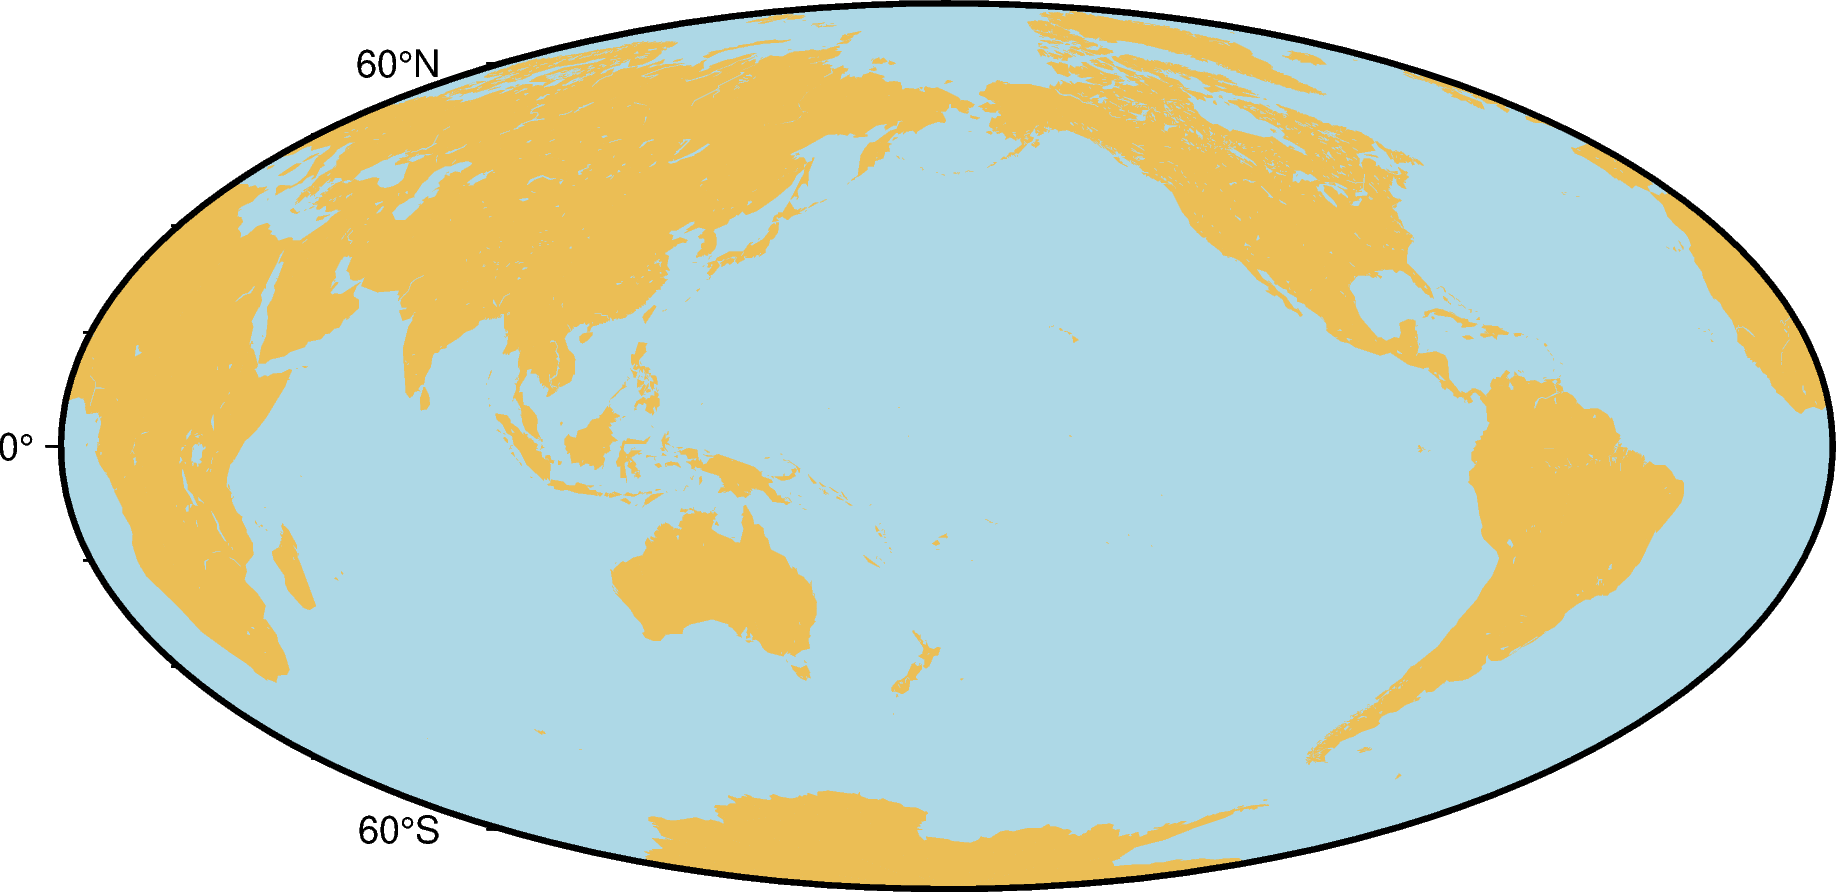

In [ ]:
fig.show()

You can also save your figure in several graphics formats (e.g., png, pdf, jpg) using `fig.savefig()`:

In [ ]:
fig.savefig("global.png")

## Example 2
Load remote dataset of earth relief. Here is the available datasets for PyGMT as of 0.10 https://www.pygmt.org/dev/api/index.html#datasets and here is the documentation on the data https://www.generic-mapping-tools.org/remote-datasets/earth-faa.html free-air anomaly data in this case.

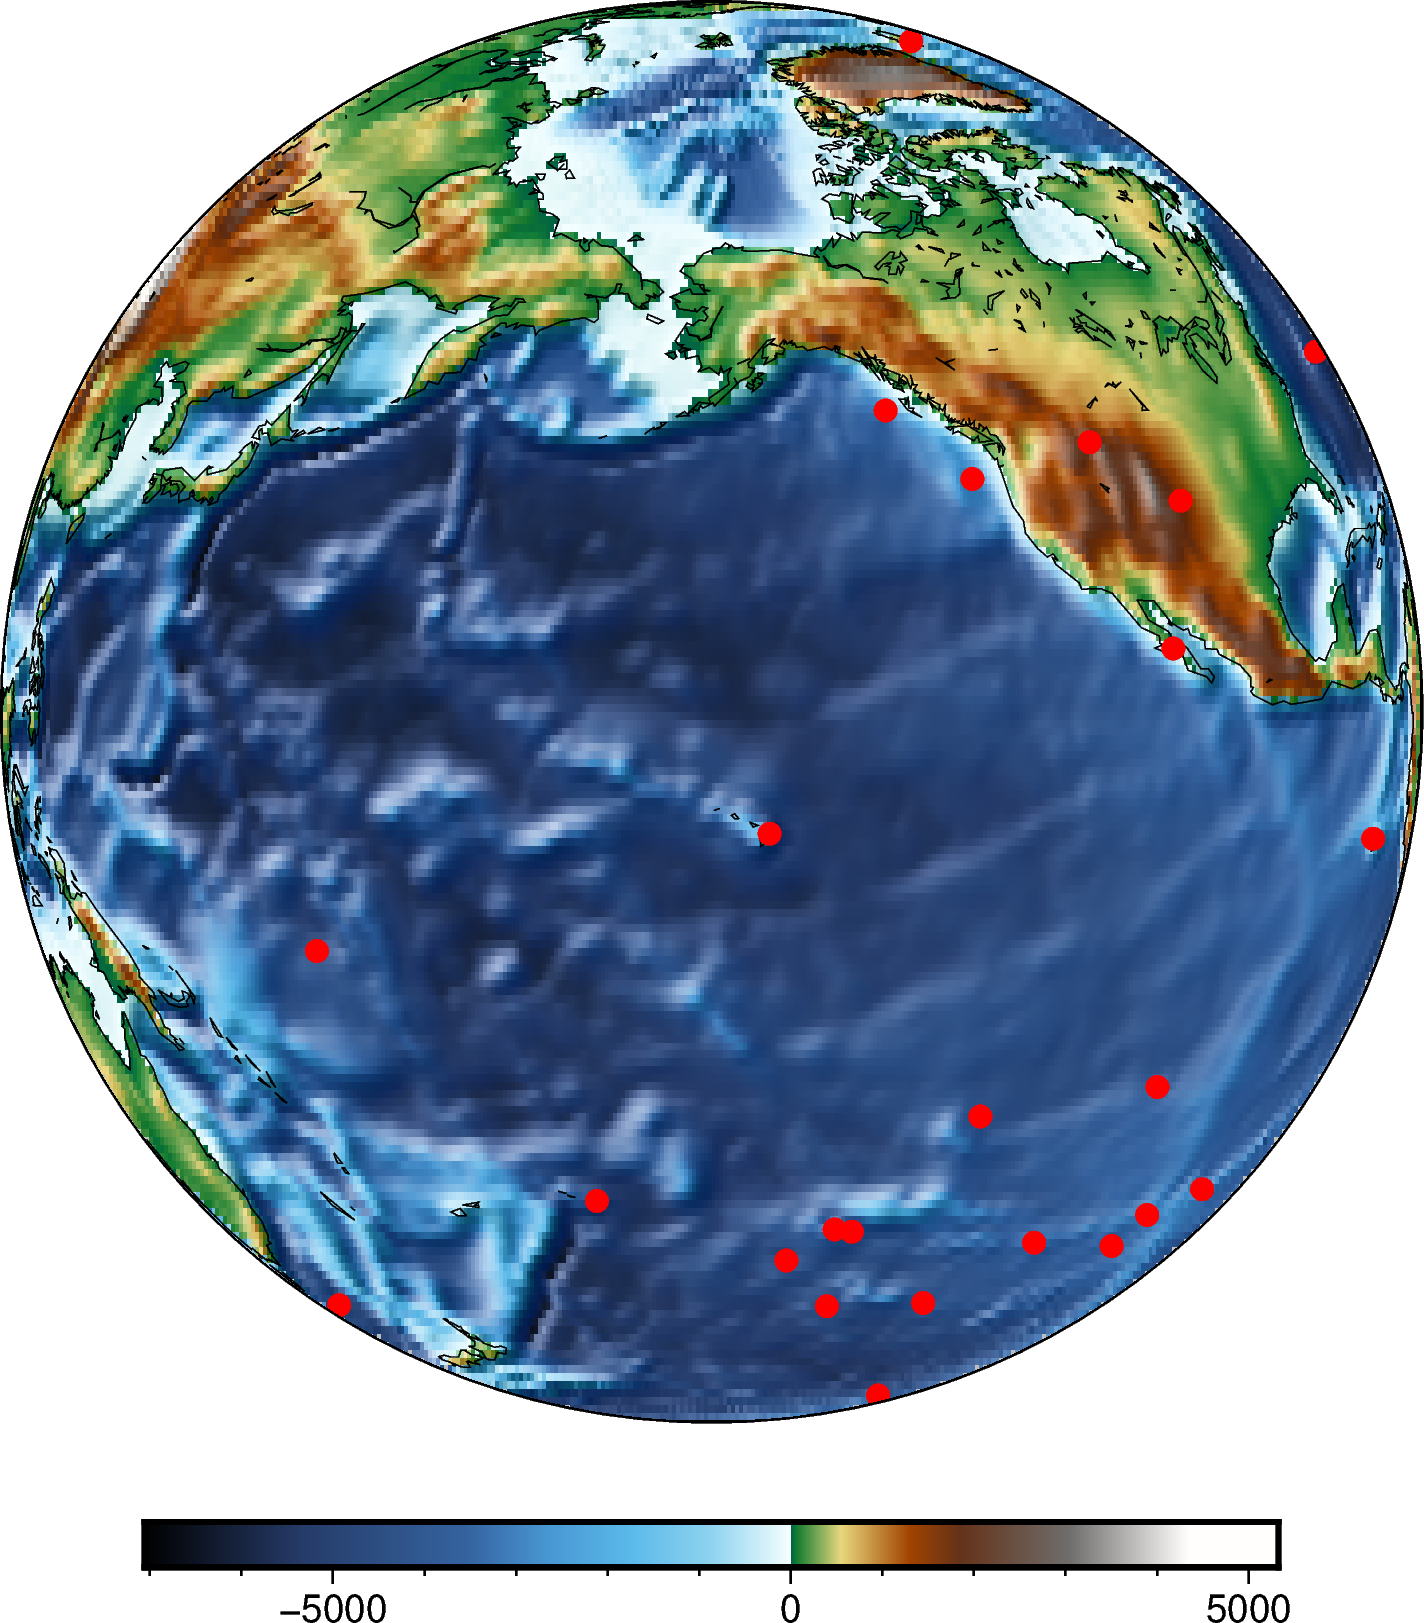

In [ ]:
from pygmt.datasets import load_earth_relief

grid = load_earth_relief(resolution='01d', registration='pixel')

fig = pygmt.Figure()
fig.basemap(region='g', projection='G200/30/12c', frame=True)
fig.grdimage(grid, cmap='geo', shading=True)
fig.coast(resolution='c', shorelines=True, area_thresh=1000)
fig.plot(data='@hotspots.txt', style='c0.2c', fill='red')
fig.colorbar()
fig.show()

## Example 3
Here we are asking USGS for nodal plane information to plot focal mechanisms for the globe. Here is the GCMT catalog website: https://www.globalcmt.org/
How different are the USGS and GCMT results?
https://www.sciencedirect.com/science/article/pii/S1674984721000690
https://www.sciencedirect.com/science/article/pii/S1674984723000344

In [ ]:
# Define start and end times
start_time = datetime(2024, 1, 1)
end_time = datetime(2024, 1, 29)
minmagnitude = 6.0

In [ ]:
# Base URL for querying USGS API
base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

def fetch_event_data(start_time, end_time, minmagnitude):
    # Set query parameters
    params = {
        "format": "geojson",
        "starttime": start_time.strftime("%Y-%m-%dT%H:%M:%S"),
        "endtime": end_time.strftime("%Y-%m-%dT%H:%M:%S"),
        "minmagnitude": minmagnitude
    }

    # Make the request
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        # Return all events
        return data["features"] if data["features"] else None
    else:
        return None

nodal_planes = []

# Fetch all events within the time span
events = fetch_event_data(start_time, end_time, minmagnitude)

def fetch_detail_data(detail_url):
    response = requests.get(detail_url)
    if response.status_code == 200:
        return response.json()
    return None

def extract_nodal_plane_info(evid, detail_data):
    """
    Extract nodal plane information (strike, dip, rake) and magnitude from the given event data.
    """
    # Check if 'moment-tensor' key exists
    if 'moment-tensor' not in detail_data['properties']['products']:
        return None  # or return a default value

    # Accessing the nested properties for the nodal plane information
    properties = detail_data['properties']['products']['moment-tensor'][0]['properties']

    # Extract nodal plane information
    strike = float(properties.get("nodal-plane-1-strike", 0))
    dip = float(properties.get("nodal-plane-1-dip", 0))
    rake = float(properties.get("nodal-plane-1-rake", 0))
    magnitude = float(detail_data['properties'].get("mag", 0))
    event_time = detail_data['properties'].get("time")
    updated_time = detail_data['properties'].get("updated")

    if event_time:
        event_time = UTCDateTime(event_time / 1000.0)

    updated_time = detail_data['properties'].get("updated")
    if updated_time:
        updated_time = UTCDateTime(updated_time / 1000.0)

    if event_time:
      event_time = UTCDateTime(event_time)
    if updated_time:
      updated_time = UTCDateTime(updated_time)

    return {
        "evid": evid,
        "strike": strike,
        "dip": dip,
        "rake": rake,
        "magnitude": magnitude,
        "event_time": event_time,
        "updated_time":updated_time
    }

nodal_planes = []

if events:
    for event in events:
        evid = event['id']
        lat = event['geometry']['coordinates'][1]
        lon = event['geometry']['coordinates'][0]
        depth = event['geometry']['coordinates'][2]
        magnitude = event['properties']['mag']

        detail_url = event['properties']['detail']
        print(f"Fetching details for event {evid} from {detail_url}")
        detail_data = fetch_detail_data(detail_url)

        if detail_data:
            nodal_plane_info = extract_nodal_plane_info(evid, detail_data)
            if nodal_plane_info:
                nodal_plane_info["depth"] = depth
                nodal_plane_info["latitude"] = lat
                nodal_plane_info["longitude"] = lon
                nodal_planes.append(nodal_plane_info)
                print(f"Nodal plane data extracted for event {evid}")
            else:
                print(f"No nodal plane data found for event {evid}")
        else:
            print(f"Failed to fetch detailed data for event {evid}.")
else:
    print(f"Failed to fetch events for the given time span.")

# Extract the longitude and latitude information from the nodal planes
lons = [plane['longitude'] for plane in nodal_planes if 'longitude' in plane]
lats = [plane['latitude'] for plane in nodal_planes if 'latitude' in plane]

len(lons), len(lats)

Fetching details for event us7000lui3 from https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000lui3&format=geojson
Nodal plane data extracted for event us7000lui3
Fetching details for event us7000luai from https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000luai&format=geojson
Nodal plane data extracted for event us7000luai
Fetching details for event us7000lt73 from https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000lt73&format=geojson
Nodal plane data extracted for event us7000lt73
Fetching details for event us7000lsze from https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000lsze&format=geojson
Nodal plane data extracted for event us7000lsze
Fetching details for event us6000m53t from https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000m53t&format=geojson
Nodal plane data extracted for event us6000m53t
Fetching details for event us6000m52p from https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000m52p&format=geojson
Noda

(11, 11)

Print out the nodal plane information so you can take a look.

In [ ]:
# Print nodal_planes list
for plane in nodal_planes:
    print(plane)

{'evid': 'us7000lui3', 'strike': 316.06, 'dip': 37.09, 'rake': -148.6, 'magnitude': 6.5, 'event_time': UTCDateTime(2024, 1, 28, 9, 38, 56, 462000), 'updated_time': UTCDateTime(2024, 2, 2, 18, 47, 15, 646000), 'depth': 619.551, 'latitude': -8.2366, 'longitude': -71.4097}
{'evid': 'us7000luai', 'strike': 74.36, 'dip': 19.05, 'rake': -141.68, 'magnitude': 6.1, 'event_time': UTCDateTime(2024, 1, 27, 5, 52, 49, 802000), 'updated_time': UTCDateTime(2024, 2, 3, 14, 9, 7, 846000), 'depth': 107.952, 'latitude': 14.1128, 'longitude': -90.5191}
{'evid': 'us7000lt73', 'strike': 270.45, 'dip': 17.32, 'rake': 36.95, 'magnitude': 6.3, 'event_time': UTCDateTime(2024, 1, 23, 14, 33, 44, 953000), 'updated_time': UTCDateTime(2024, 1, 29, 4, 10, 39, 906000), 'depth': 31, 'latitude': -17.9961, 'longitude': 168.0457}
{'evid': 'us7000lsze', 'strike': 235.43, 'dip': 44.78, 'rake': 41.97, 'magnitude': 7.0, 'event_time': UTCDateTime(2024, 1, 22, 18, 9, 4, 480000), 'updated_time': UTCDateTime(2024, 1, 30, 18, 22

For the focal mechanism itself we need the strike, dip, and rake. Magnitude and depth are going to be our size and color in the plot.

In [ ]:
strikes = [plane['strike'] for plane in nodal_planes]
dips = [plane['dip'] for plane in nodal_planes]
rakes = [plane['rake'] for plane in nodal_planes]
magnitudes = [plane['magnitude'] for plane in nodal_planes]
depths = [float(plane['depth']) for plane in nodal_planes]

# Normalize depth values for colormap
depths_normalized = (np.array(depths) - min(depths)) / (max(depths) - min(depths))
colormap = pygmt.makecpt(cmap="rainbow", series=[0, 1], continuous=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
<ipython-input-212-e02d83485b4d>:42: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(region = [0, 26, 0, 26], projection = 'M4', x = 18, y = yval1, style = 'c' + str(np.exp(8/1.7)*0.008), pen = '1.2p,black', color = col_leg)
<ipython-input-212-e02d83485b4d>:43: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = 13, y = yval1, style = 'c' + str(np.exp(7/1.7)*0.008) , pen = '1.2p,black', color = col_leg)
<ipython-input-212-e02d83485b4d>:44: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = 9, y = yval1, style = 'c' + str(np.exp(6/1.7)*0.008) , pen = '1.2p,black', color = col_leg)


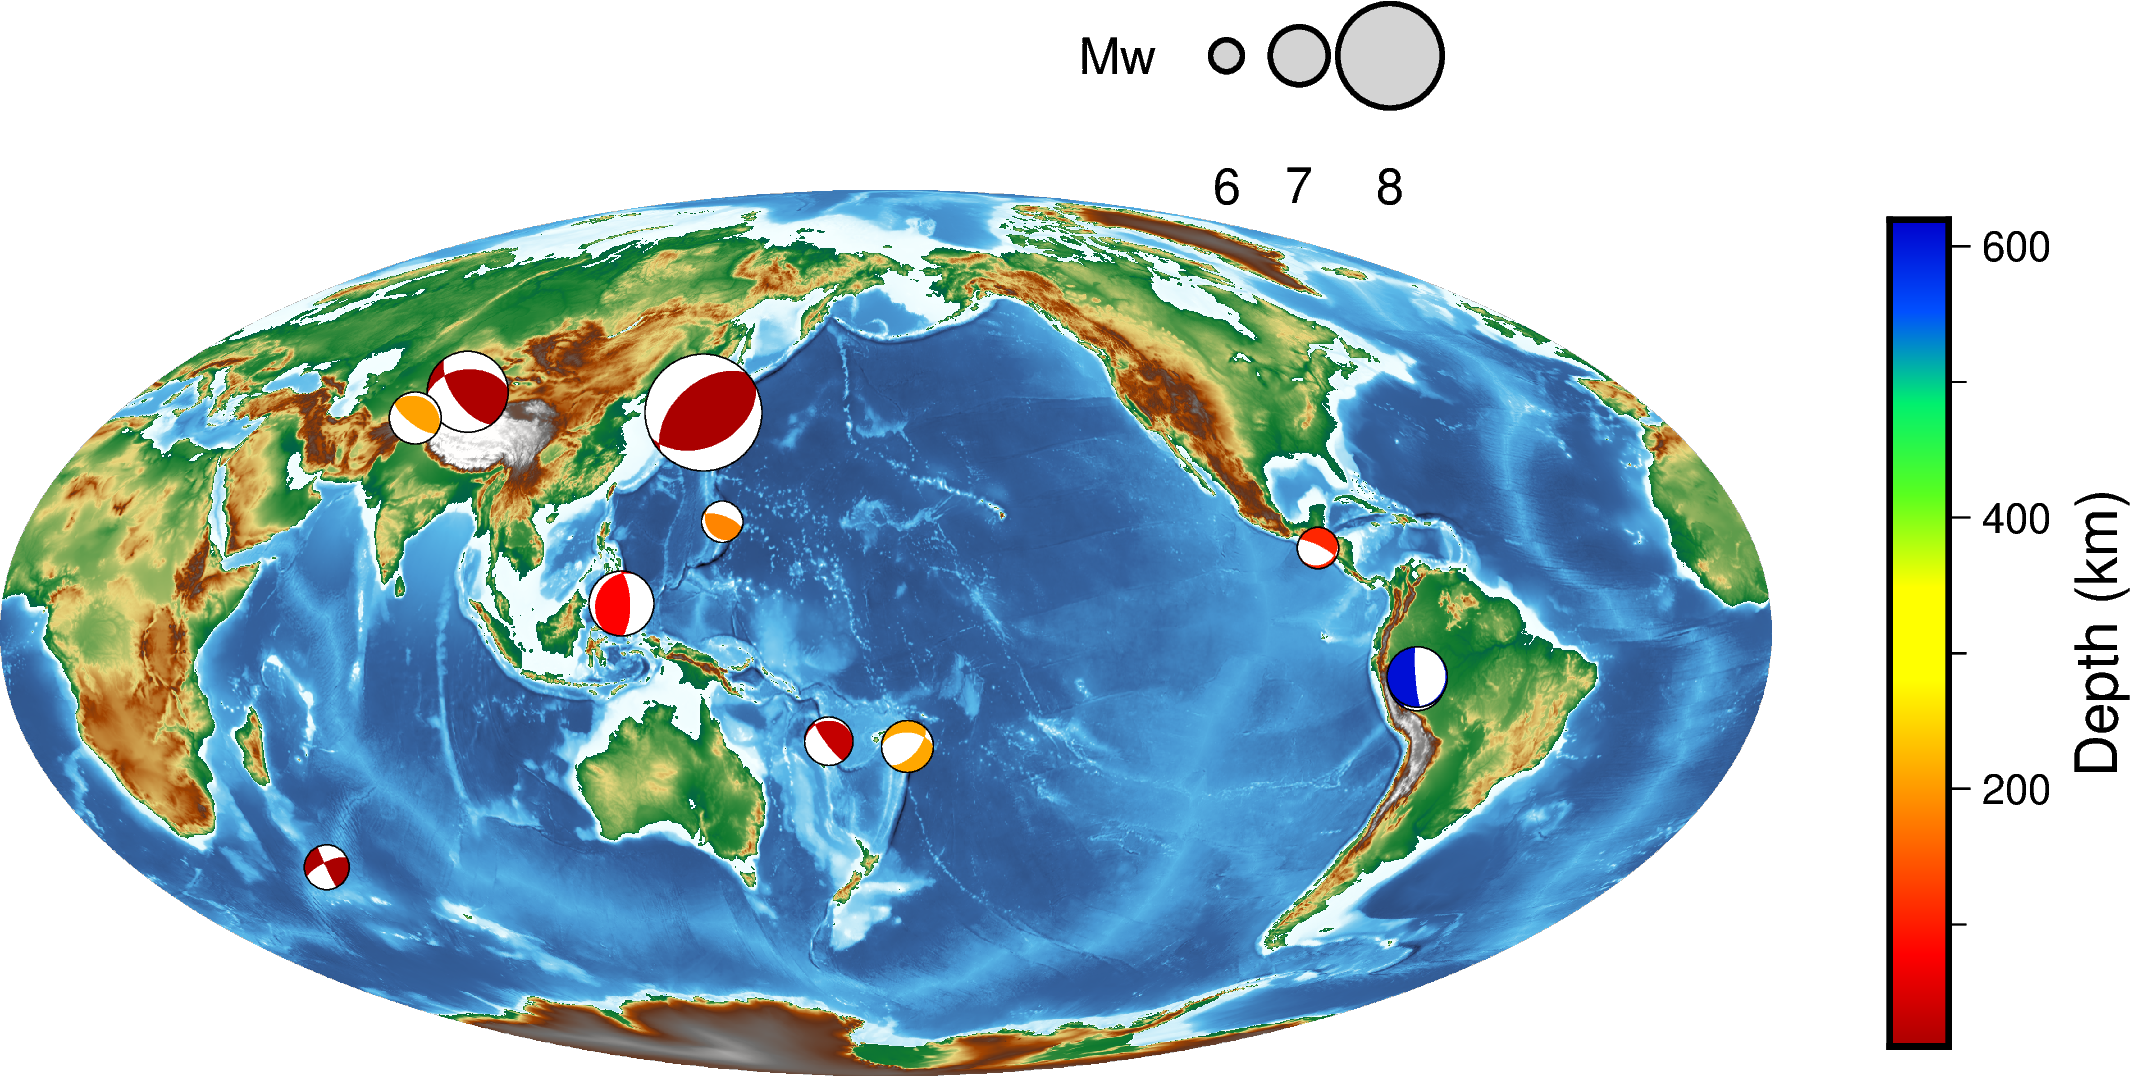

In [ ]:
fig = pygmt.Figure()


fig.grdimage(grid = "@earth_relief_10m",region='g',projection="W15c",cmap="geo")


events_dicts = []
for i in range(len(lons)):
    event_dict = {
        "longitude": lons[i],
        "latitude": lats[i],
        "depth": depths[i], # this will be used for coloring
        "strike": strikes[i],
        "dip": dips[i],
        "rake": rakes[i],
        "magnitude": magnitudes[i] # this will be used for scaling
    }
    events_dicts.append(event_dict)

# Create a colormap for depth
colormap = pygmt.makecpt(cmap="seis", series=[min(depths), max(depths)], continuous=True)

for event in events_dicts:
    # Adjust scale based on magnitude using exponential scaling.
    scale_value = f"{np.exp(event['magnitude']/1.7)*0.008}c"
    fig.meca(
        spec=event,
        convention="aki",
        scale=scale_value,
        cmap=True
    )
fig.colorbar(position="JMR+o1c/0c+w7c/0.5c+mc",frame='af+l"Depth (km)"')


col_leg = 'lightgray'

fig.shift_origin(xshift = '9c', yshift = '6.0c')

# plot circles
yval1 = 17
#fig.plot(region = [0, 26, 0, 26], projection = 'M4', x = 22, y = yval1, style = 'c' + str(np.exp(9/1.7)*0.0057), pen = '1.2p,black', color = col_leg)
fig.plot(region = [0, 26, 0, 26], projection = 'M4', x = 18, y = yval1, style = 'c' + str(np.exp(8/1.7)*0.008), pen = '1.2p,black', color = col_leg)
fig.plot(x = 13, y = yval1, style = 'c' + str(np.exp(7/1.7)*0.008) , pen = '1.2p,black', color = col_leg)
fig.plot(x = 9, y = yval1, style = 'c' + str(np.exp(6/1.7)*0.008) , pen = '1.2p,black', color = col_leg)
#fig.plot(x = 5.6, y = yval1, style = 'c' + str(np.exp(6/1.7)*0.0057) , pen = '1.2p,black', color = col_leg)

# add annotations
yval2 = 10
#fig.text(x = 22 , y = yval2 , text = '9', font = '12p')
fig.text(x = 18 , y = yval2 , text = '8', font = '12p')
fig.text(x = 13 , y = yval2 , text = '7', font = '12p')
fig.text(x = 9 , y = yval2 , text = '6', font = '12p')
#fig.text(x = 5.6 , y = yval2 , text = '6', font = '12p')
fig.text(x = 3 , y = yval1 , text = 'Mw', font = '12p')

fig.show()

## Example 4
Change to your specific region you would like to plot in and see the earthquakes. We are collecting all the earthquake information still but now the functions are going to restrict the output to our latitude and longitude bounds.

In [ ]:
# Define start and end times
start_time = datetime(2000, 1, 1)
end_time = datetime(2024, 2, 1)
minmagnitude = 6.5

region = [-129,-109,27,53] ## Western North America
#region = [156, 213, 44, 60] ## Alaska
#region = [125, 149, 28, 47] ## Japan
#region = [-111, -80, 7, 28] ## Mexico
#region =  [-86, -61, -55, 3] ## South America

In [ ]:
# Base URL for querying USGS API
base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

def fetch_event_data(start_time, end_time, minmagnitude):
    # Set query parameters
    params = {
        "format": "geojson",
        "starttime": start_time.strftime("%Y-%m-%dT%H:%M:%S"),
        "endtime": end_time.strftime("%Y-%m-%dT%H:%M:%S"),
        "minmagnitude": minmagnitude
    }

    # Make the request
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        # Return all events
        return data["features"] if data["features"] else None
    else:
        return None

nodal_planes = []

# Fetch all events within the time span
events = fetch_event_data(start_time, end_time, minmagnitude)

def fetch_detail_data(detail_url):
    response = requests.get(detail_url)
    if response.status_code == 200:
        return response.json()
    return None

def extract_nodal_plane_info(evid, detail_data):
    """
    Extract nodal plane information (strike, dip, rake) and magnitude from the given event data.
    """
    # Check if 'moment-tensor' key exists
    if 'moment-tensor' not in detail_data['properties']['products']:
        return None  # or return a default value

    # Accessing the nested properties for the nodal plane information
    properties = detail_data['properties']['products']['moment-tensor'][0]['properties']

    # Extract nodal plane information
    strike = float(properties.get("nodal-plane-1-strike", 0))
    dip = float(properties.get("nodal-plane-1-dip", 0))
    rake = float(properties.get("nodal-plane-1-rake", 0))
    magnitude = float(detail_data['properties'].get("mag", 0))  # This remains at the higher level
    event_time = detail_data['properties'].get("time")
    updated_time = detail_data['properties'].get("updated")

    if event_time:
        event_time = UTCDateTime(event_time / 1000.0)

    updated_time = detail_data['properties'].get("updated")
    if updated_time:
        updated_time = UTCDateTime(updated_time / 1000.0)

    if event_time:
      event_time = UTCDateTime(event_time)
    if updated_time:
      updated_time = UTCDateTime(updated_time)

    return {
        "evid": evid,
        "strike": strike,
        "dip": dip,
        "rake": rake,
        "magnitude": magnitude,
        "event_time": event_time,
        "updated_time":updated_time
    }


nodal_planes = []

# Define region boundaries
lon_min, lon_max, lat_min, lat_max = region

# Fetch all events within the time span
events = fetch_event_data(start_time, end_time, minmagnitude)

if events:
    for event in events:
        evid = event['id']
        lat = event['geometry']['coordinates'][1]
        lon = event['geometry']['coordinates'][0]
        depth = event['geometry']['coordinates'][2]
        magnitude = event['properties']['mag']

        # Check if event is within the defined region
        if lon_min <= lon <= lon_max and lat_min <= lat <= lat_max:
            detail_url = event['properties']['detail']
            print(f"Fetching details for event {evid} from {detail_url}")  # Diagnostic print
            detail_data = fetch_detail_data(detail_url)

            if detail_data:
                nodal_plane_info = extract_nodal_plane_info(evid, detail_data)
                if nodal_plane_info:  # Check if a nodal plane was extracted
                    nodal_plane_info["depth"] = depth
                    nodal_plane_info["latitude"] = lat
                    nodal_plane_info["longitude"] = lon
                    nodal_planes.append(nodal_plane_info)
                    print(f"Nodal plane data extracted for event {evid}")
                else:
                    print(f"No nodal plane data found for event {evid}")
            else:
                print(f"Failed to fetch detailed data for event {evid}.")
        else:
            print(f"Event {evid} is outside the defined region.")
else:
    print(f"Failed to fetch events for the given time span.")

# Extract the longitude and latitude information from the nodal planes
lons = [plane['longitude'] for plane in nodal_planes if 'longitude' in plane]
lats = [plane['latitude'] for plane in nodal_planes if 'latitude' in plane]

len(lons), len(lats)

Event us7000lui3 is outside the defined region.
Event us7000lsze is outside the defined region.
Event us6000m52p is outside the defined region.
Event us6000m2jp is outside the defined region.
Event us6000m0xl is outside the defined region.
Event pt23364001 is outside the defined region.
Event us6000m05c is outside the defined region.
Event us7000lgwp is outside the defined region.
Event us7000lfxx is outside the defined region.
Event us7000lftp is outside the defined region.
Event us7000lff4 is outside the defined region.
Event us7000le6w is outside the defined region.
Event us6000lqf9 is outside the defined region.
Event us6000lq00 is outside the defined region.
Event us6000lp12 is outside the defined region.
Event us7000l9ku is outside the defined region.
Event us7000l9h4 is outside the defined region.
Event us7000l9h2 is outside the defined region.
Event us7000l7si is outside the defined region.
Event us7000l7qy is outside the defined region.
Event us6000ldqf is outside the defined 

(16, 16)

In [ ]:
# Print nodal_planes list
for plane in nodal_planes:
    print(plane)

{'evid': 'nn00725272', 'strike': 168.46, 'dip': 66.74, 'rake': -167.11, 'magnitude': 6.5, 'event_time': UTCDateTime(2020, 5, 15, 11, 3, 27, 176000), 'updated_time': UTCDateTime(2023, 8, 25, 20, 46, 8, 292000), 'depth': 2.7, 'latitude': 38.1689, 'longitude': -117.8497}
{'evid': 'us70008jr5', 'strike': 269.12, 'dip': 67.2, 'rake': -162.65, 'magnitude': 6.5, 'event_time': UTCDateTime(2020, 3, 31, 23, 52, 30, 781000), 'updated_time': UTCDateTime(2023, 11, 27, 2, 38, 57, 327000), 'depth': 12.06, 'latitude': 44.4646, 'longitude': -115.1175}
{'evid': 'ci38457511', 'strike': 0.0, 'dip': 0.0, 'rake': 0.0, 'magnitude': 7.1, 'event_time': UTCDateTime(2019, 7, 6, 3, 19, 53, 40000), 'updated_time': UTCDateTime(2024, 1, 29, 20, 28, 14, 917000), 'depth': 8, 'latitude': 35.7695, 'longitude': -117.5993333}
{'evid': 'us20007z6r', 'strike': 95.0, 'dip': 81.0, 'rake': -158.0, 'magnitude': 6.6, 'event_time': UTCDateTime(2016, 12, 8, 14, 49, 45, 910000), 'updated_time': UTCDateTime(2022, 5, 3, 18, 4, 29, 55

In [ ]:
strikes = [plane['strike'] for plane in nodal_planes]
dips = [plane['dip'] for plane in nodal_planes]
rakes = [plane['rake'] for plane in nodal_planes]
magnitudes = [plane['magnitude'] for plane in nodal_planes]
depths = [float(plane['depth']) for plane in nodal_planes]

# Normalize depth values for colormap
depths_normalized = (np.array(depths) - min(depths)) / (max(depths) - min(depths))
colormap = pygmt.makecpt(cmap="rainbow", series=[0, 1], continuous=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
<ipython-input-324-4751e86f282e>:42: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(region = [0, 26, 0, 26], projection = 'M4', x = 18, y = yval1, style = 'c' + str(np.exp(8/1.7)*0.008), pen = '1.2p,black', color = col_leg)
<ipython-input-324-4751e86f282e>:43: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = 13, y = yval1, style = 'c' + str(np.exp(7/1.7)*0.008) , pen = '1.2p,black', color = col_leg)
<ipython-input-324-4751e86f282e>:44: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x = 9, y = yval1, style = 'c' + str(np.exp(6/1.7)*0.008) , pen = '1.2p,black', color = col_leg)


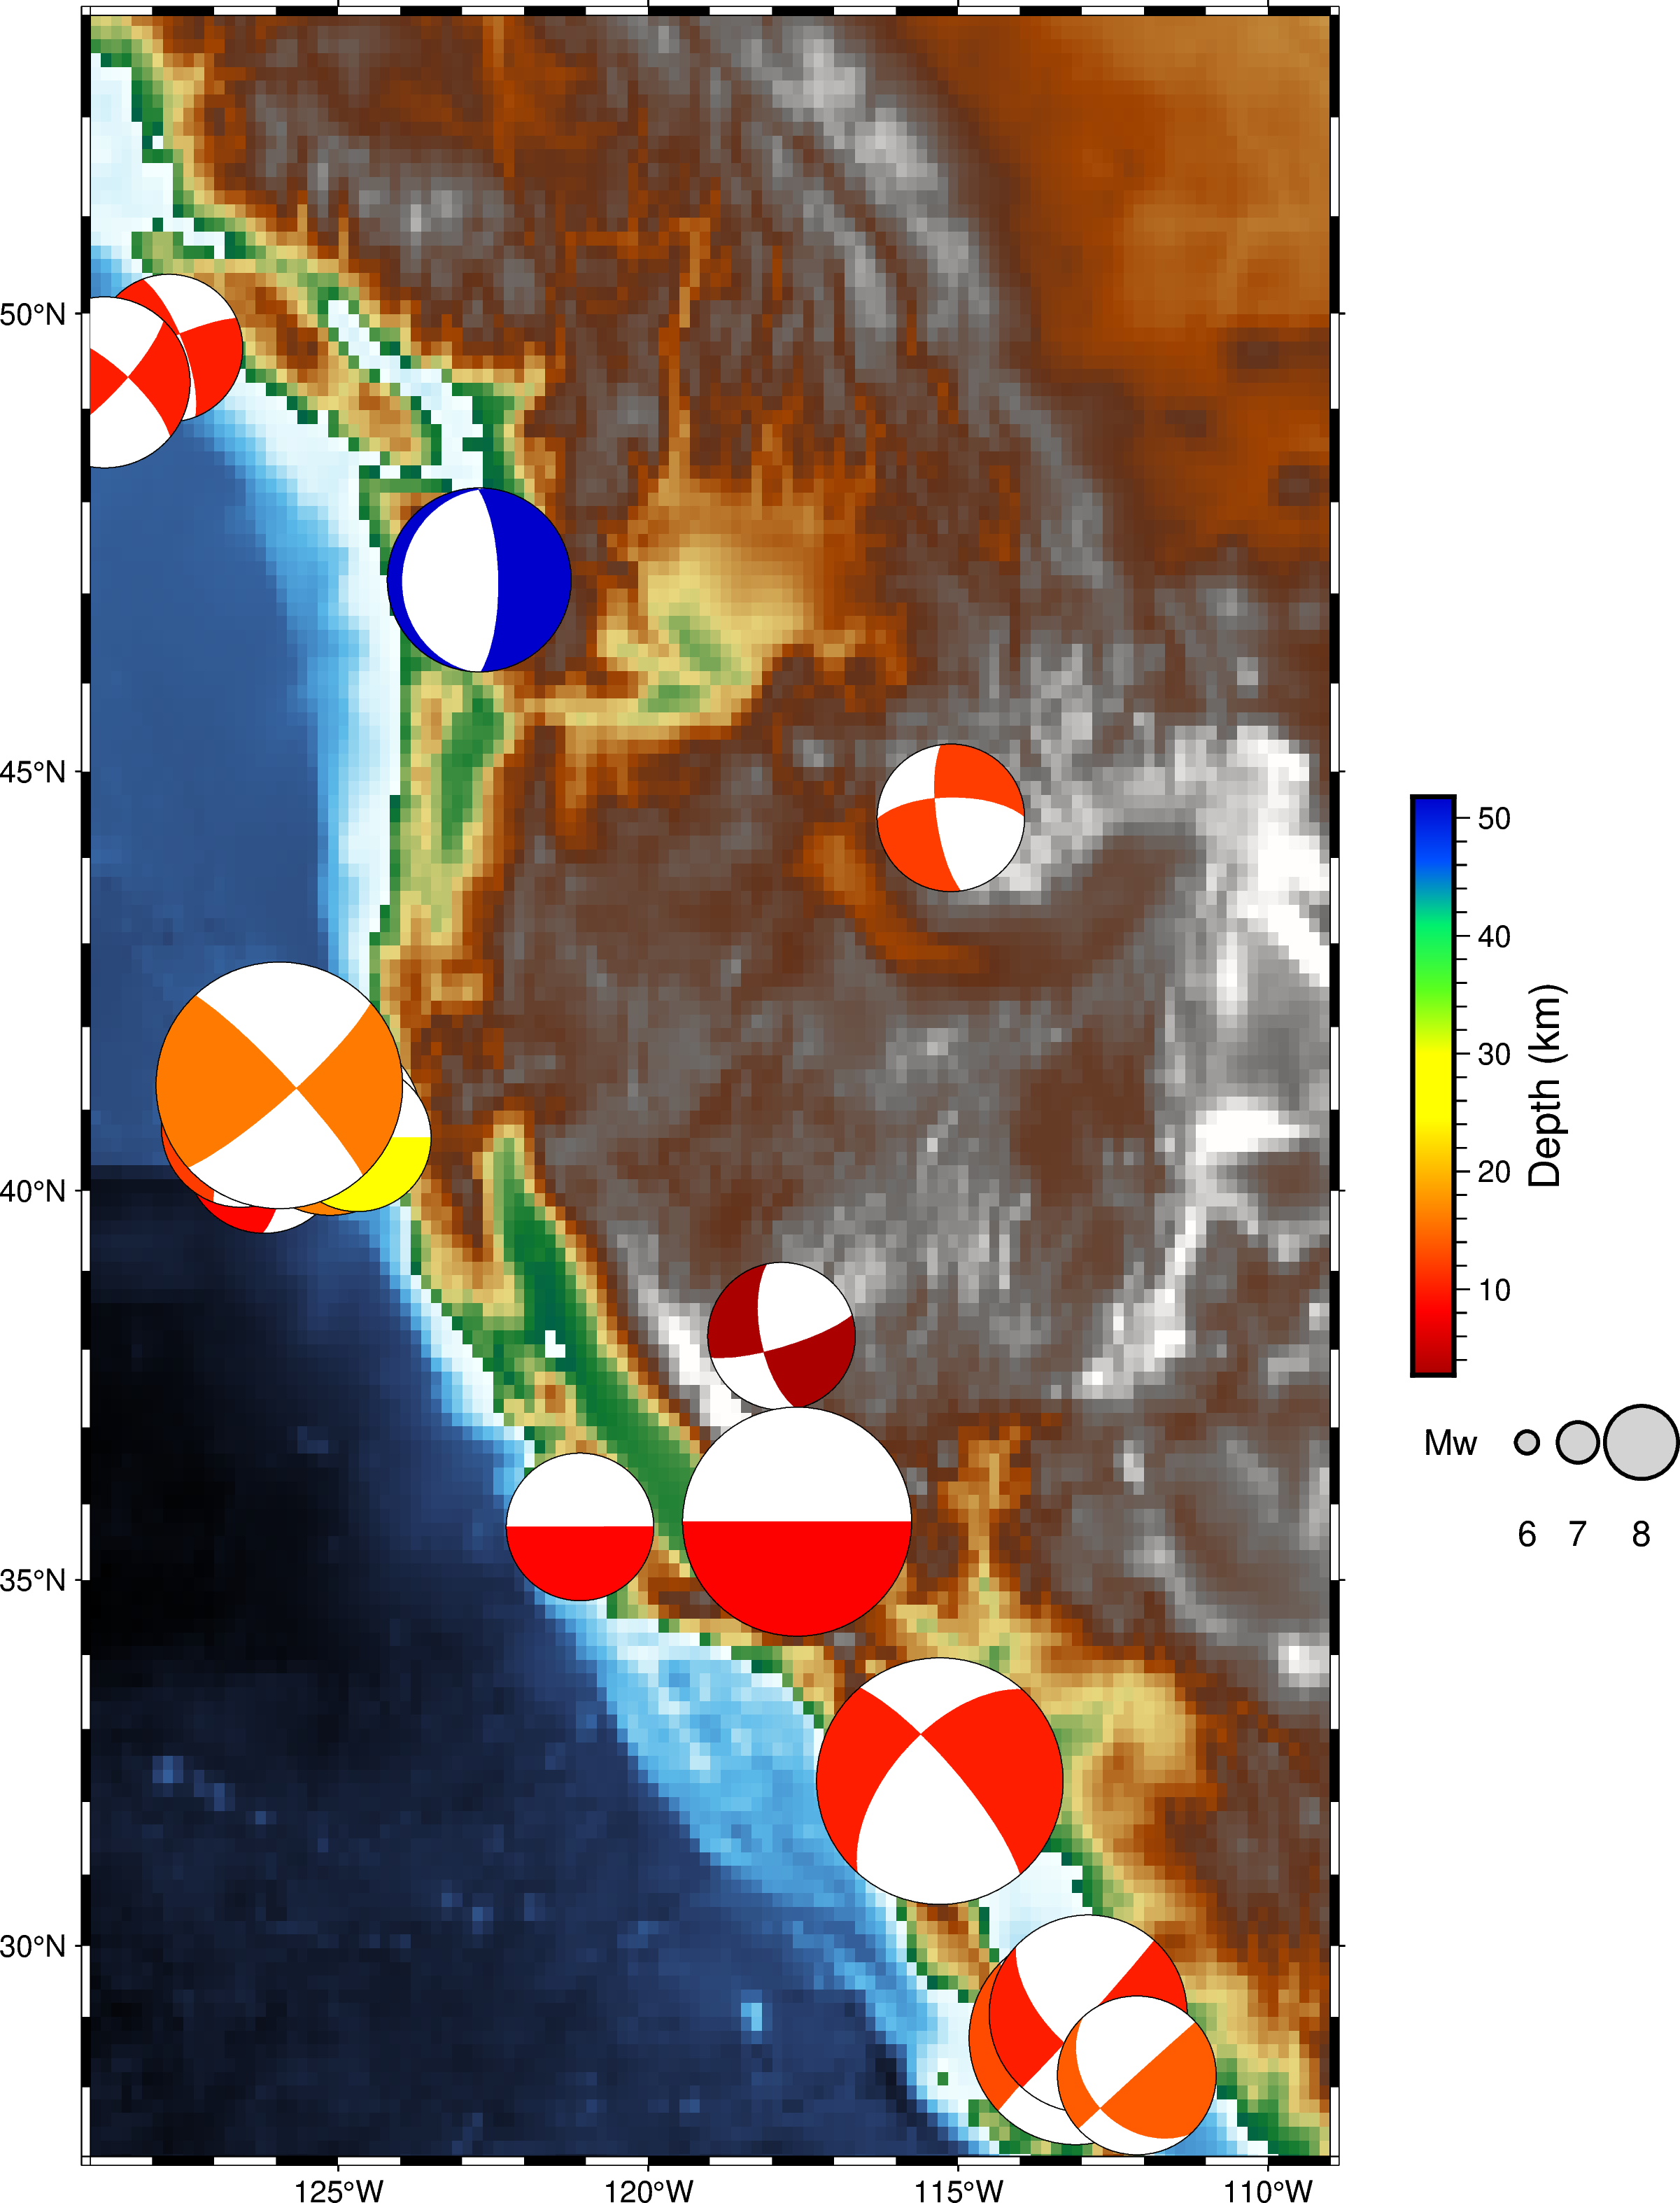

In [ ]:
fig = pygmt.Figure()


fig.grdimage(grid = "@earth_relief_10m",region=region,projection="M15c",cmap="geo",frame=True)


events_dicts = []
for i in range(len(lons)):
    event_dict = {
        "longitude": lons[i],
        "latitude": lats[i],
        "depth": depths[i], # this will be used for coloring
        "strike": strikes[i],
        "dip": dips[i],
        "rake": rakes[i],
        "magnitude": magnitudes[i] # this will be used for scaling
    }
    events_dicts.append(event_dict)

# Create a colormap for depth
colormap = pygmt.makecpt(cmap="seis", series=[min(depths), max(depths)], continuous=True)

for event in events_dicts:
    # Adjust scale based on magnitude using exponential scaling.
    scale_value = f"{np.exp(event['magnitude']/1.7)*0.03}c"
    fig.meca(
        spec=event,
        convention="aki",
        scale=scale_value,
        cmap=True
    )
fig.colorbar(position="JMR+o1c/0c+w7c/0.5c+mc",frame='af+l"Depth (km)"')


col_leg = 'lightgray'

fig.shift_origin(xshift = '16c', yshift = '6.0c')

# plot circles
yval1 = 17
#fig.plot(region = [0, 26, 0, 26], projection = 'M4', x = 22, y = yval1, style = 'c' + str(np.exp(9/1.7)*0.0057), pen = '1.2p,black', color = col_leg)
fig.plot(region = [0, 26, 0, 26], projection = 'M4', x = 18, y = yval1, style = 'c' + str(np.exp(8/1.7)*0.008), pen = '1.2p,black', color = col_leg)
fig.plot(x = 13, y = yval1, style = 'c' + str(np.exp(7/1.7)*0.008) , pen = '1.2p,black', color = col_leg)
fig.plot(x = 9, y = yval1, style = 'c' + str(np.exp(6/1.7)*0.008) , pen = '1.2p,black', color = col_leg)
#fig.plot(x = 5.6, y = yval1, style = 'c' + str(np.exp(6/1.7)*0.0057) , pen = '1.2p,black', color = col_leg)

# add annotations
yval2 = 10
#fig.text(x = 22 , y = yval2 , text = '9', font = '12p')
fig.text(x = 18 , y = yval2 , text = '8', font = '12p')
fig.text(x = 13 , y = yval2 , text = '7', font = '12p')
fig.text(x = 9 , y = yval2 , text = '6', font = '12p')
#fig.text(x = 5.6 , y = yval2 , text = '6', font = '12p')
fig.text(x = 3 , y = yval1 , text = 'Mw', font = '12p')

fig.show()

As of PyGMT 0.10.0 the 'coupe' module is not implemented to plot a depth cross-section of our focal mechanism. Here we extract the information into a text file so we can make a separate plot in GMT. Google colab can download directly from this code cell.

In [ ]:

with open("nodal_planes_data.txt", "w") as file:
    for plane in nodal_planes:
        # Format: lon, lat, depth, strike, dip, rake, magnitude
        # Add optional fields if needed
        line = f"{plane['longitude']} {plane['latitude']} {plane['depth']} {plane['strike']} {plane['dip']} {plane['rake']} {plane['magnitude']}\n"
        file.write(line)

from google.colab import files
files.download('nodal_planes_data.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Example 4
We have selected a region of interest and plotted earthquakes over a time period. Now let's take a look at the seismograms for that earthquake around the world using Seisbench to denoise and pick arrivals. In this example we are getting the event and waveforms from a to a station in Tucson.
This tutorial is supplied by the seisbench folks from: https://colab.research.google.com/github/seisbench/seisbench/blob/main/examples/02a_deploy_model_on_streams_example.ipynb#scrollTo=tZSXpHELQ6QB

In [ ]:
import seisbench
import seisbench.models as sbm
import matplotlib.pyplot as plt
import numpy as np
import obspy
from tqdm.notebook import tqdm
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import scipy.stats

In [ ]:
# pn_model.cuda();
# eqt_model.cuda();
# gpd_model.cuda();

In this example I find the largest magnitude or deepest events. Depending on the time span and the region this might not look so good in TUC. You can use the IRIS GMap to take a look at available stations and networks: https://ds.iris.edu/gmap/
The Obspy documentation also lists available clients to extract data from: https://docs.obspy.org/packages/obspy.clients.fdsn.html

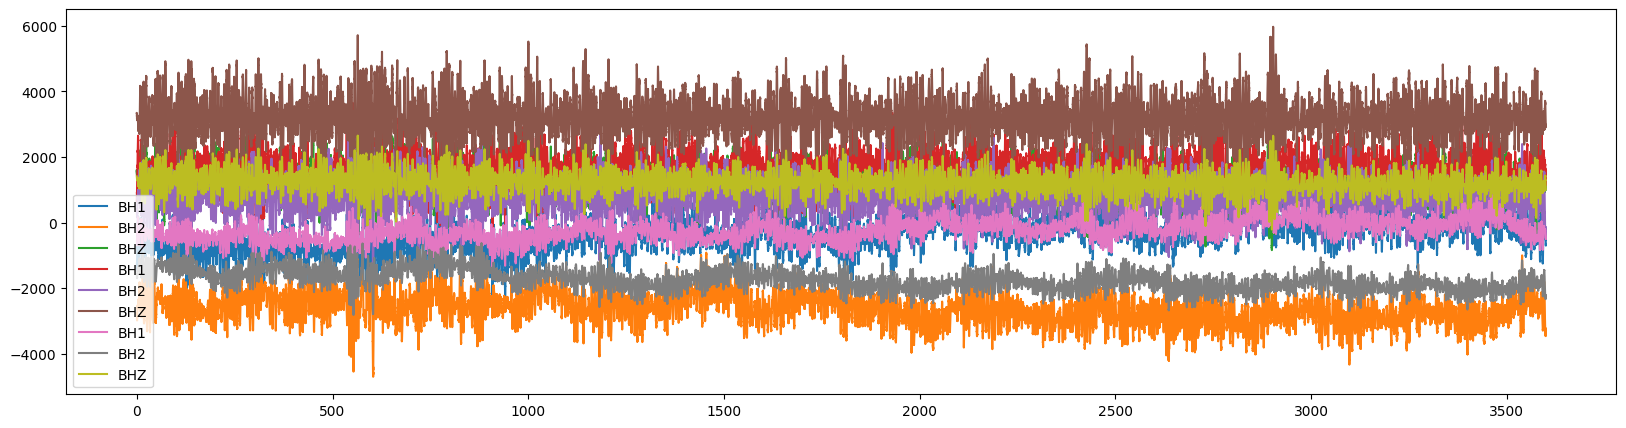

In [ ]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

# Find the largest magnitude and deepest events
largest_event = max(nodal_planes, key=lambda x: x['magnitude'])
deepest_event = max(nodal_planes, key=lambda x: x['depth'])

client = Client("IRIS")

# Use the updated time of the largest event or deepest depth
t = largest_event['updated_time']
#t = deepest_event['updated_time']

network = "IU"
station = "TUC"
channel = "BH*"

# Fetch waveforms

stream = client.get_waveforms(network=network, station=station, location="*", channel=channel, starttime=t, endtime=t+3600)

# Plotting the waveforms
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(len(stream)):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()
plt.show()


In [ ]:
largest_event

{'evid': 'ci14607652',
 'strike': 222.0,
 'dip': 59.0,
 'rake': -14.0,
 'magnitude': 7.2,
 'event_time': 2010-04-04T22:40:42.360000Z,
 'updated_time': 2023-11-21T20:25:22.190000Z,
 'depth': 9.987,
 'latitude': 32.2861667,
 'longitude': -115.2953333}

In [ ]:
deepest_event

{'evid': 'uw10530748',
 'strike': 359.0,
 'dip': 73.0,
 'rake': 268.0,
 'magnitude': 6.8,
 'event_time': 2001-02-28T18:54:32.830000Z,
 'updated_time': 2023-10-12T05:12:21.953000Z,
 'depth': 51.798,
 'latitude': 47.149,
 'longitude': -122.7266667}

#### Here you can download your pretrained model for predicting on the example streams.
if you would like to see the full suite of available pre-trained weights for any model, you can call the ```list_pretrained``` method, which will return all the associated weights for the model, along with information on the training procedure for each set of weights. For the purposes of this plug-in-and-play example, we comment out a number of available models, for you to load and try out.

In [ ]:
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")
# pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT
eqt_model = sbm.EQTransformer.from_pretrained("original")
# eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
# eqt_model = sbm.EQTransformer.from_pretrained("scedc")
# eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD
# gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")

We can apply our varying models now to the seismic stream through the high level ```annotate``` method. This will output the charactersitic functions for the probability of a P-phase, S-phase, and noise class respectively.

In [ ]:
pn_preds = pn_model.annotate(stream)
eqt_preds = eqt_model.annotate(stream)
gpd_preds = gpd_model.annotate(stream)

pn_preds

/usr/local/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/usr/local/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)
Task was destroyed but it is pending!
task: <Task pending name='Task-736' coro=<WaveformModel._async_annotate_window_pre() running at /usr/local/lib/python3.10/site-packages/seisbench/models/base.py:1386> wait_for=<Future pending cb=[Task.__wakeup()]>>


9 Trace(s) in Stream:
IU.TUC.00.PhaseNet_P | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.00.PhaseNet_S | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.00.PhaseNet_N | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.10.PhaseNet_P | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.10.PhaseNet_S | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.10.PhaseNet_N | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.60.PhaseNet_P | 2023-11-21T20:25:24.720000Z - 2023-11-21T21:25:19.710000Z | 100.0 Hz, 359500 samples
IU.TUC.60.PhaseNet_S | 2023-11-21T20:25:24.720000Z - 2023-11-21T21:25:19.710000Z | 100.0 Hz, 359500 samples
IU.TUC.60.PhaseNet_N | 2023-11-21T20:25:24.720000Z - 2023-11-21T21:25:19.710000Z | 100.0 Hz, 359500 samples

Enter window length in seconds, and define which model predictions you would like to plot

In [ ]:
wlength = 5 * 60 #@param

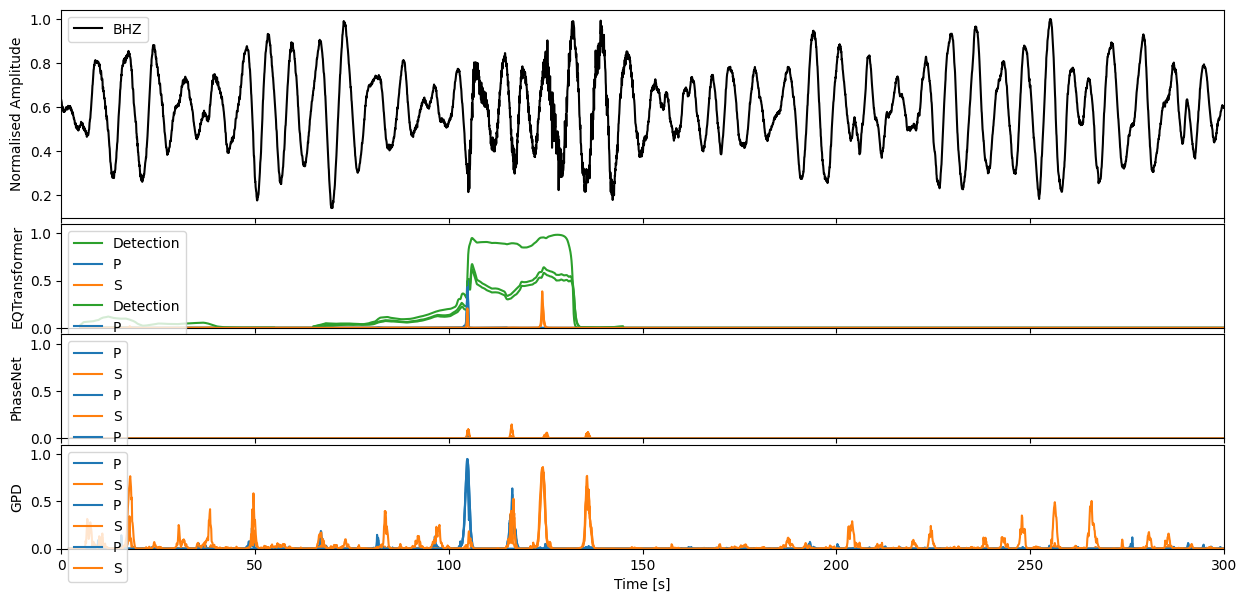

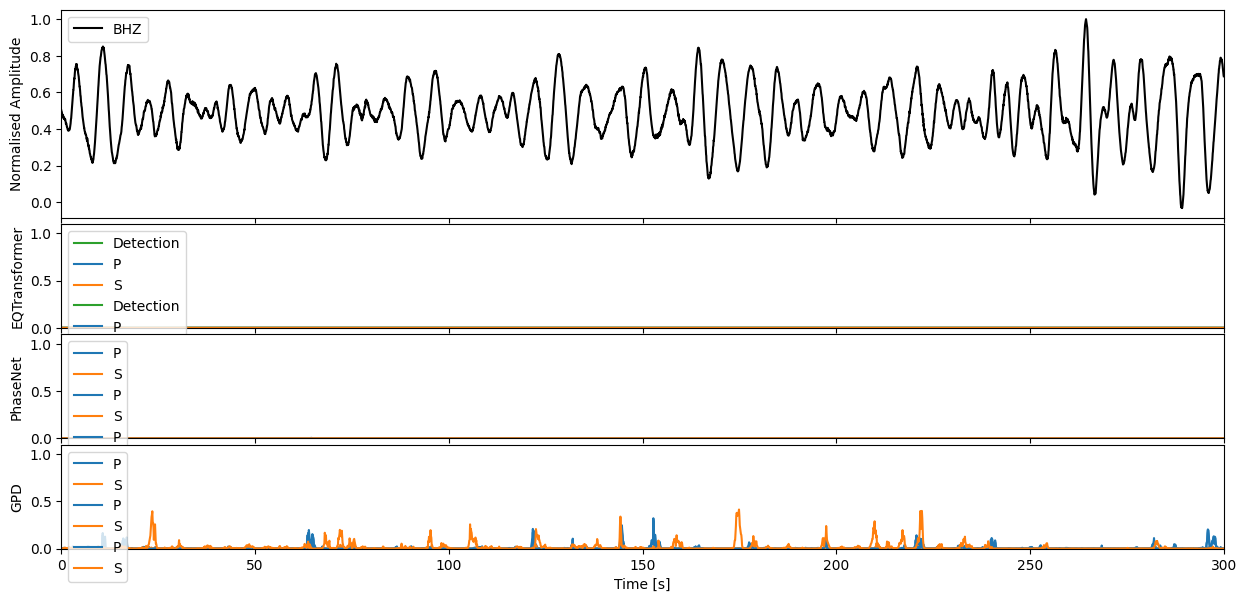

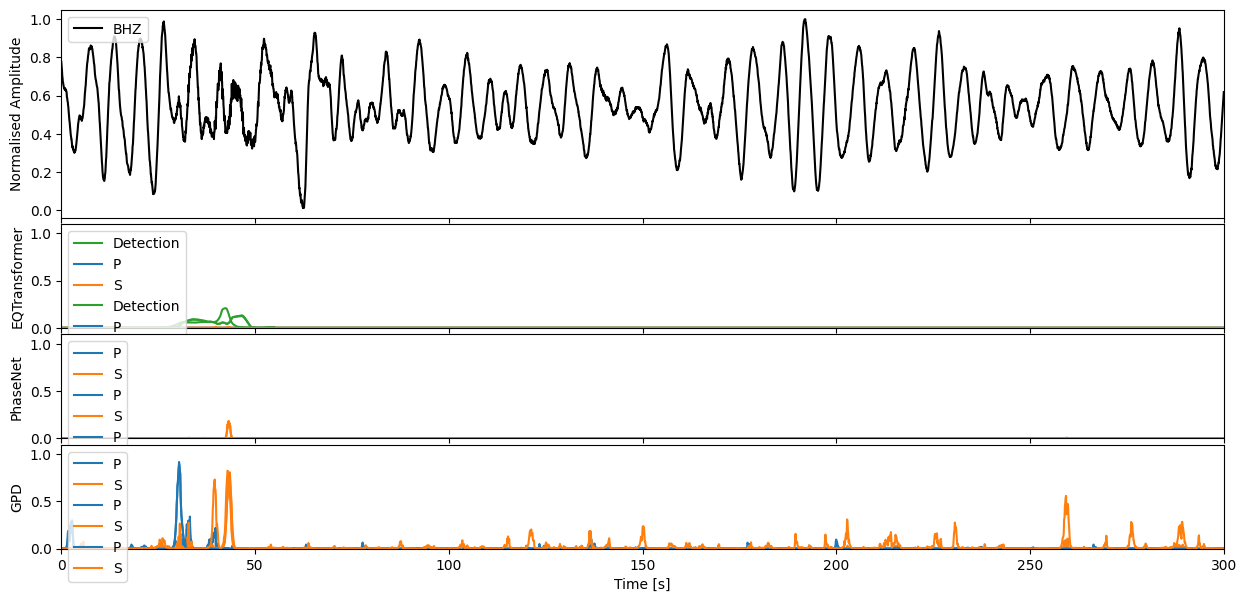

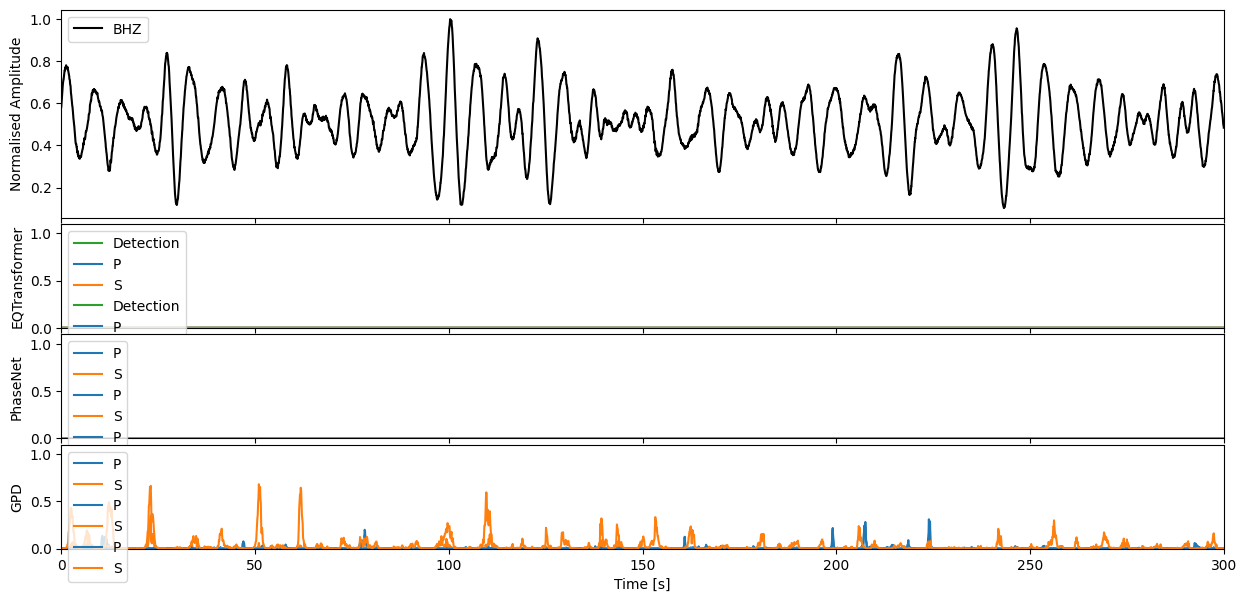

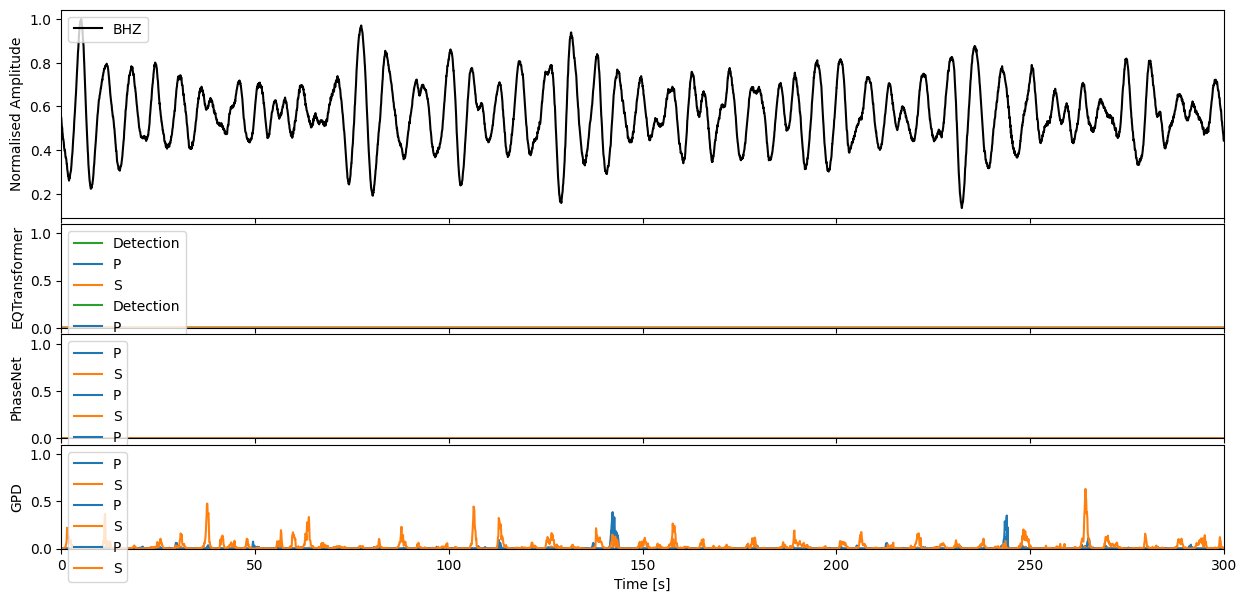

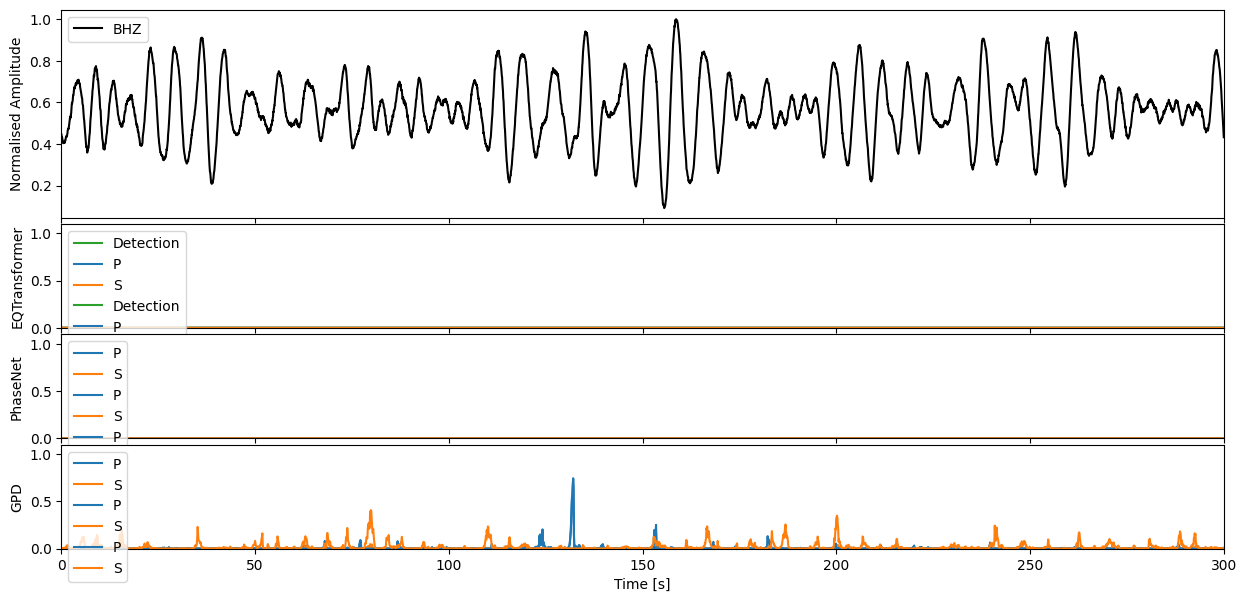

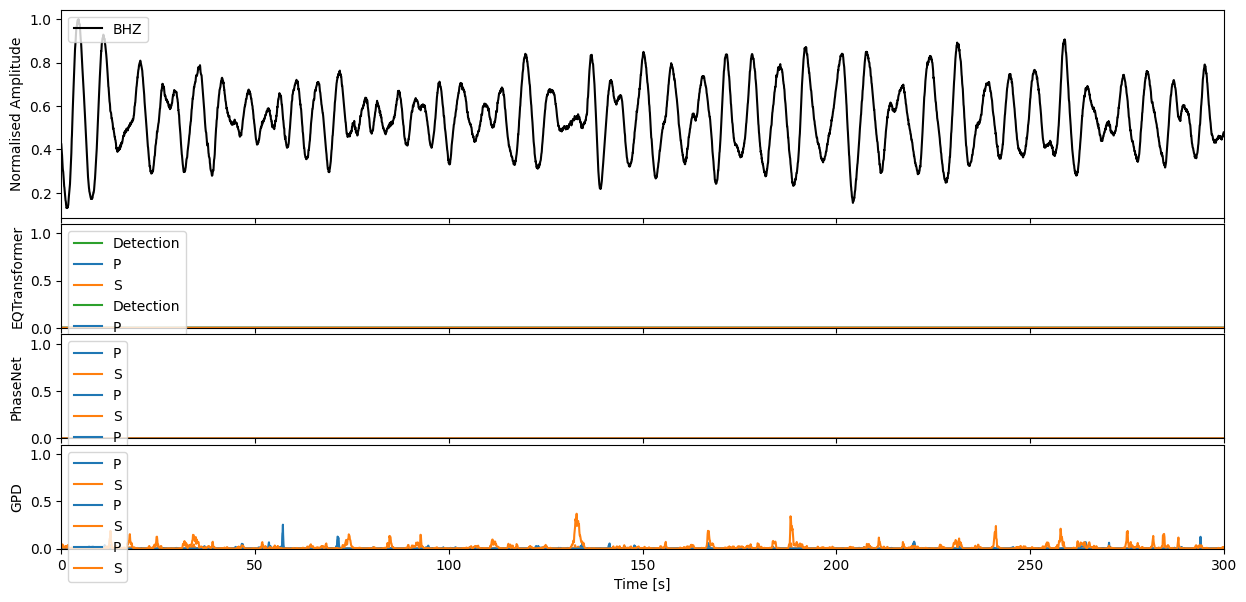

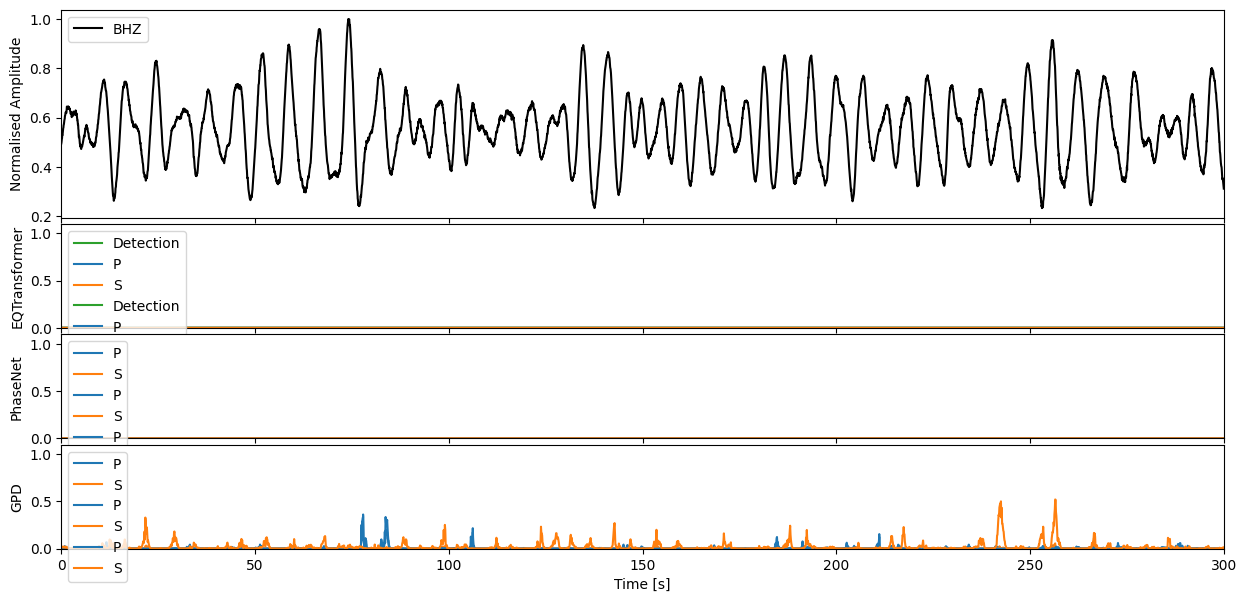

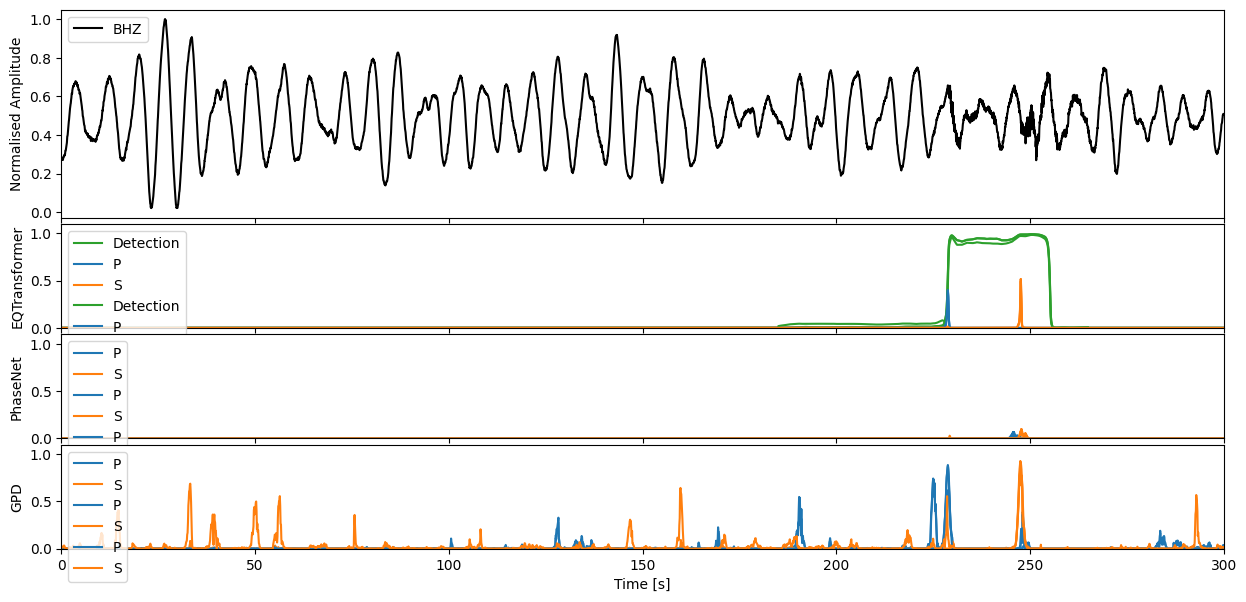

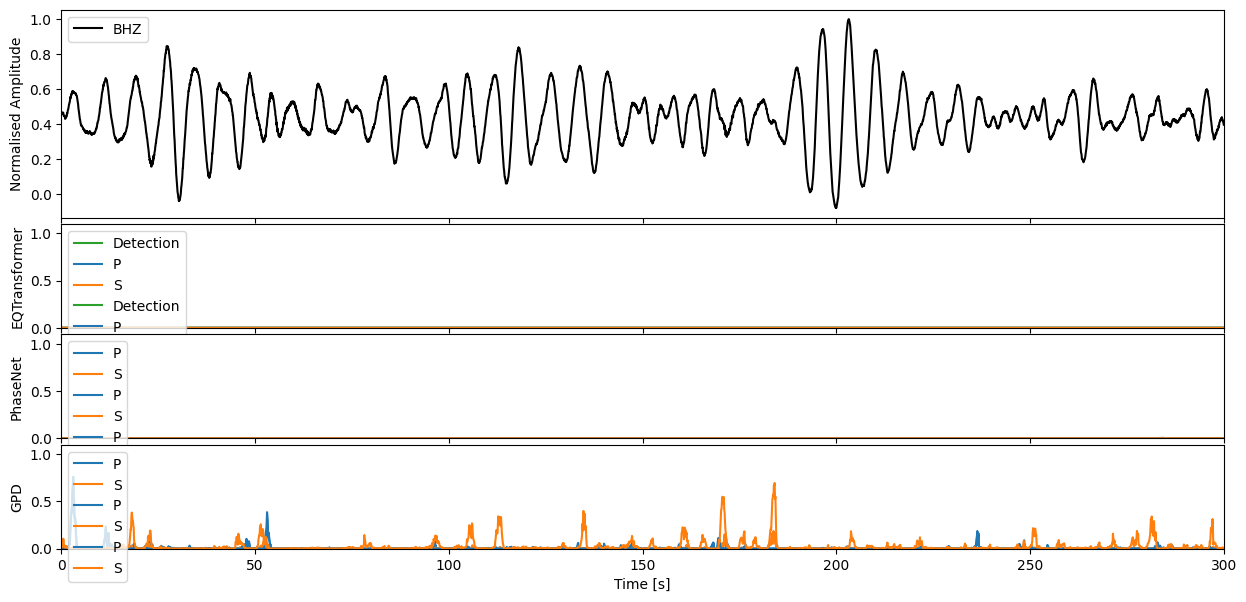

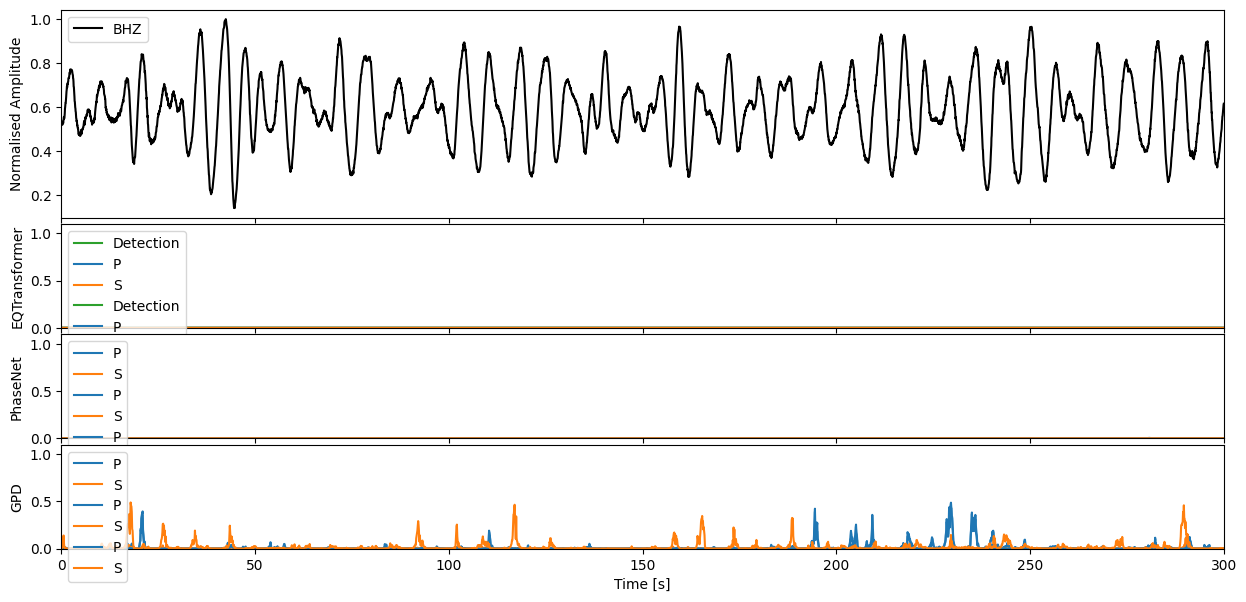

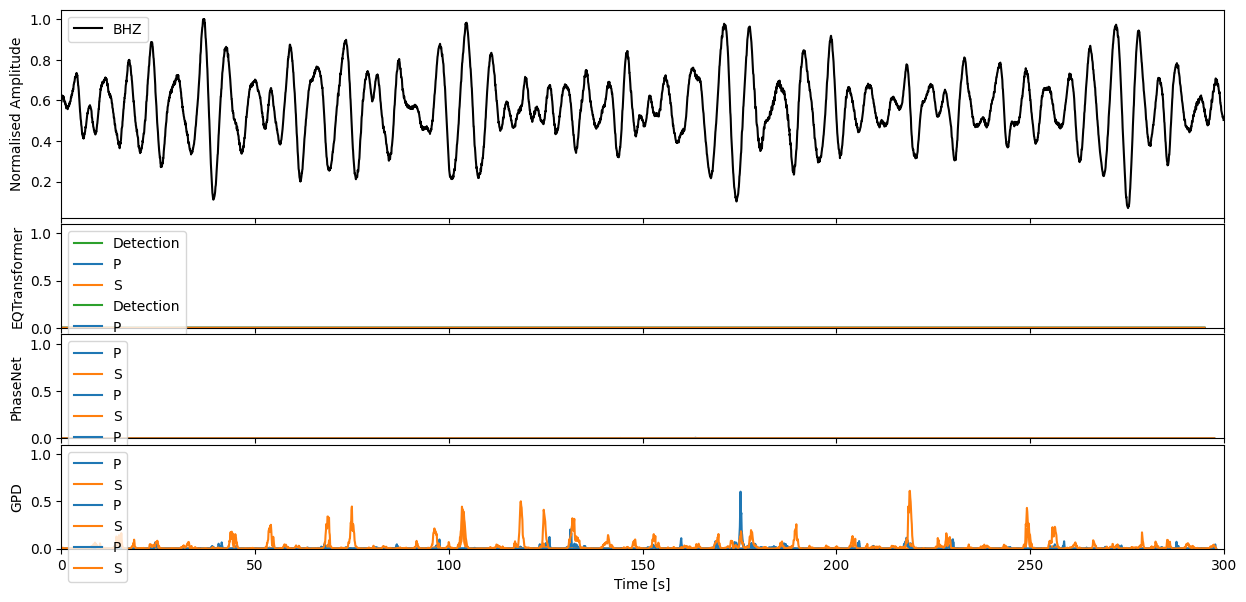

In [ ]:
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}

for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.slice(t0, t1)

    fig, ax = plt.subplots(4, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1, 1]})

    for i, preds in enumerate([eqt_preds, pn_preds, gpd_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                # Skip noise traces
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(model)
        ax[i + 1].legend(loc=2)
        ax[i + 1].set_ylim(0, 1.1)

    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[3].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.show()

If you would like to then make deterministic detections from the continuous characteristic functions, the ```classify``` method of each model will allow you to perform this task.

In [ ]:
outputs = pn_model.classify(stream)

In [ ]:
print(outputs)

ClassifyOutput(creator='PhaseNet', picks=PickList with 0 entries:

)


We can use DeepDenoiser to try and see if we can clean our seismograms a little bit for the picking. This is the same Google Colab notebook for DeepDenoiser in Seisbench but we apply this to our event we have chosen in this workflow:
https://colab.research.google.com/github/seisbench/seisbench/blob/main/examples/02b_deep_denoiser.ipynb


This tutorial shows how to apply DeepDenoiser (Zhu et al 2019) and how using deep denoiser can significantly improve picking models.

We load the DeepDenoiser model through SeisBench, using the (converted) original weights from Zhu et al (2019).

In [390]:
model = sbm.DeepDenoiser.from_pretrained("original")

As with the picking models, we can use the ```annotate``` function to apply DeepDenoiser to a stream.

In [ ]:
annotations = model.annotate(stream)

Visualize the denoised data.

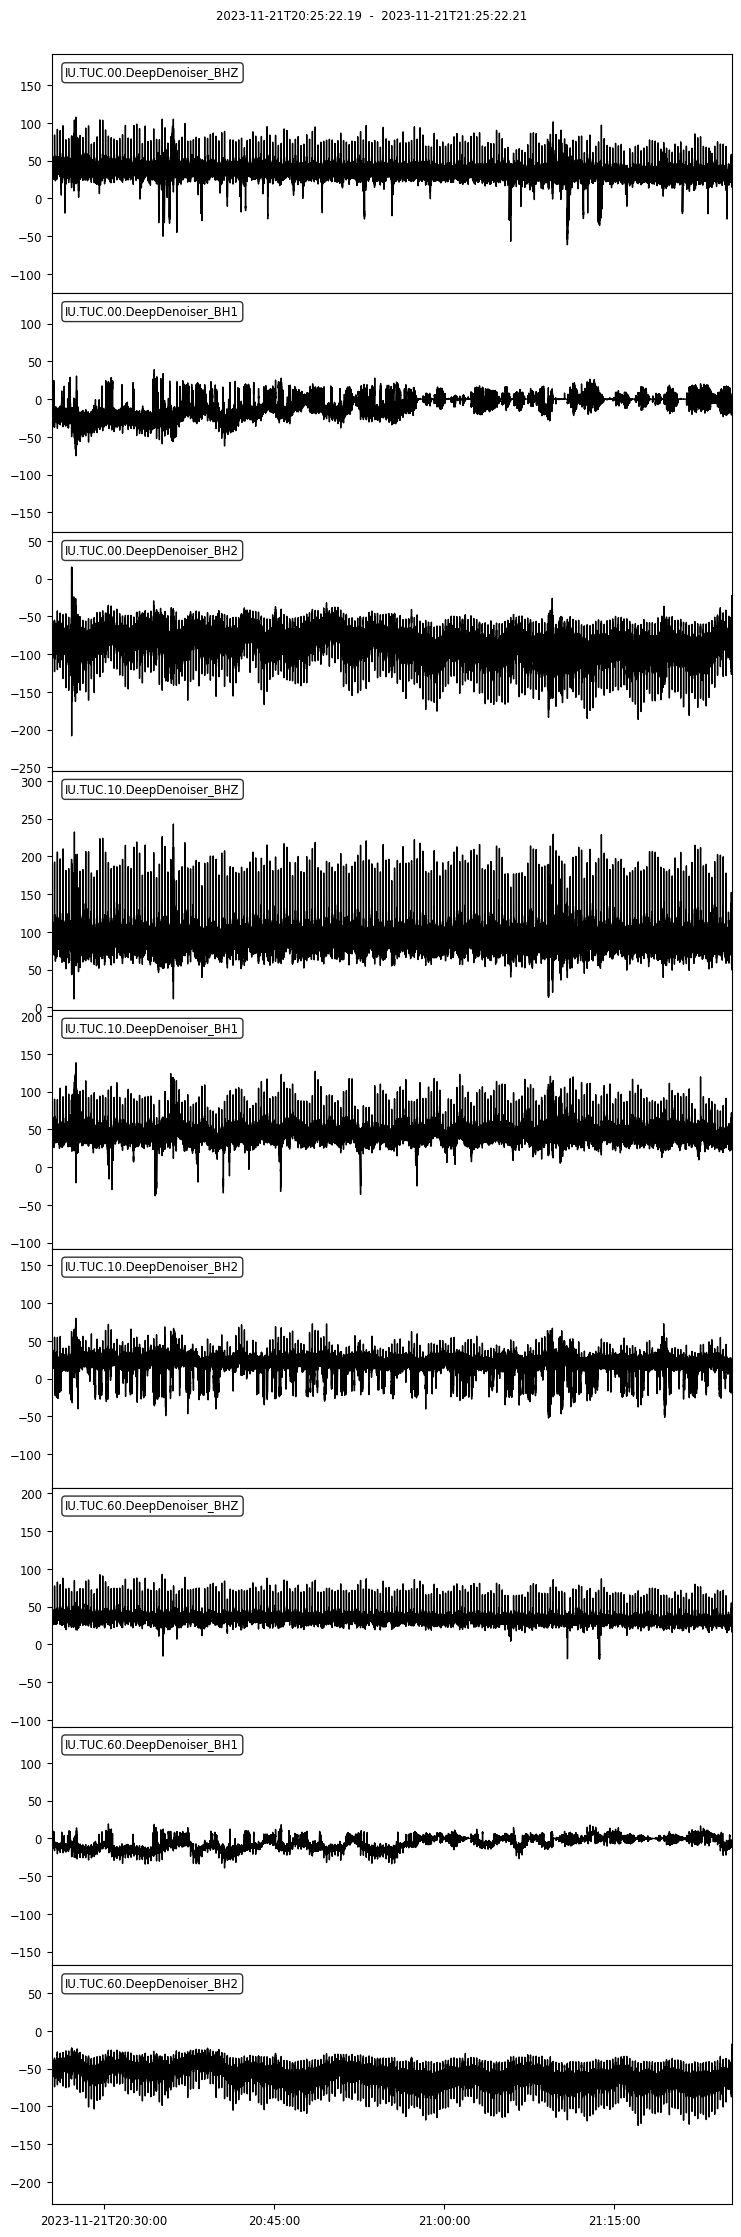

In [ ]:
annotations.plot();

## Influence of denoising on picking

Does denoising make it better to visualize earthquakes? But how about coupling denoising with an automatic picking algorithm? Below we use EQTransformer to annotate the original stream (top) and then the denoised stream (bottom).

In [ ]:
picker = sbm.EQTransformer.from_pretrained("instance")

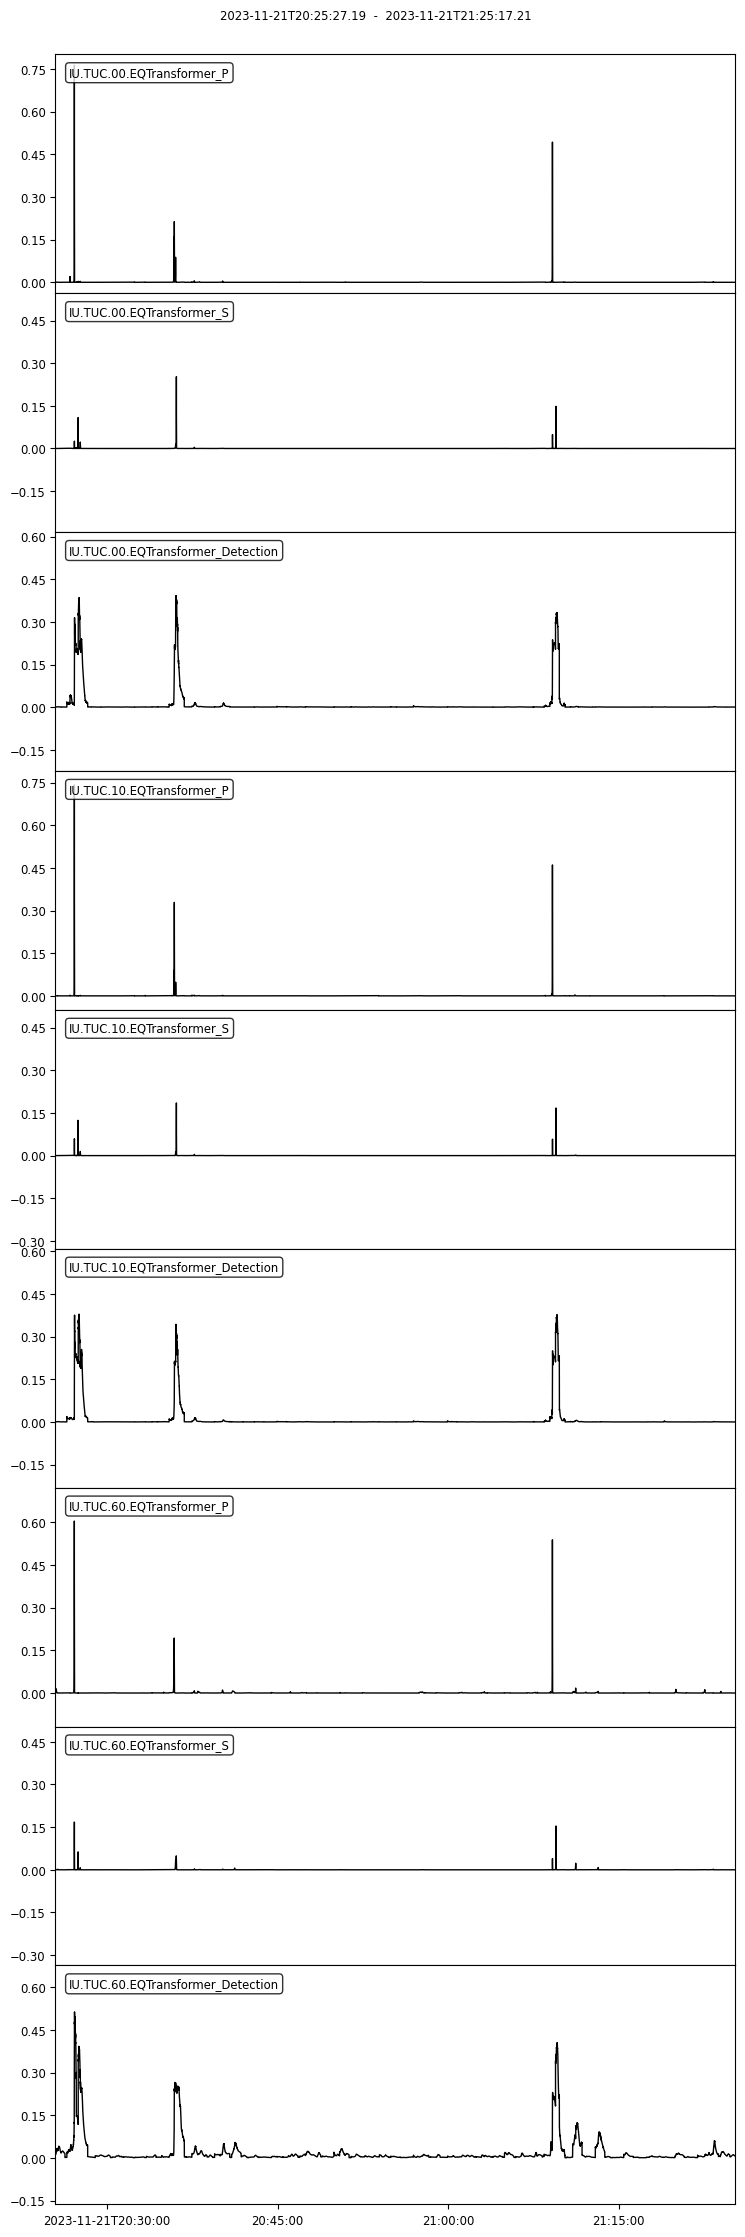

In [ ]:
picker.annotate(stream).plot();

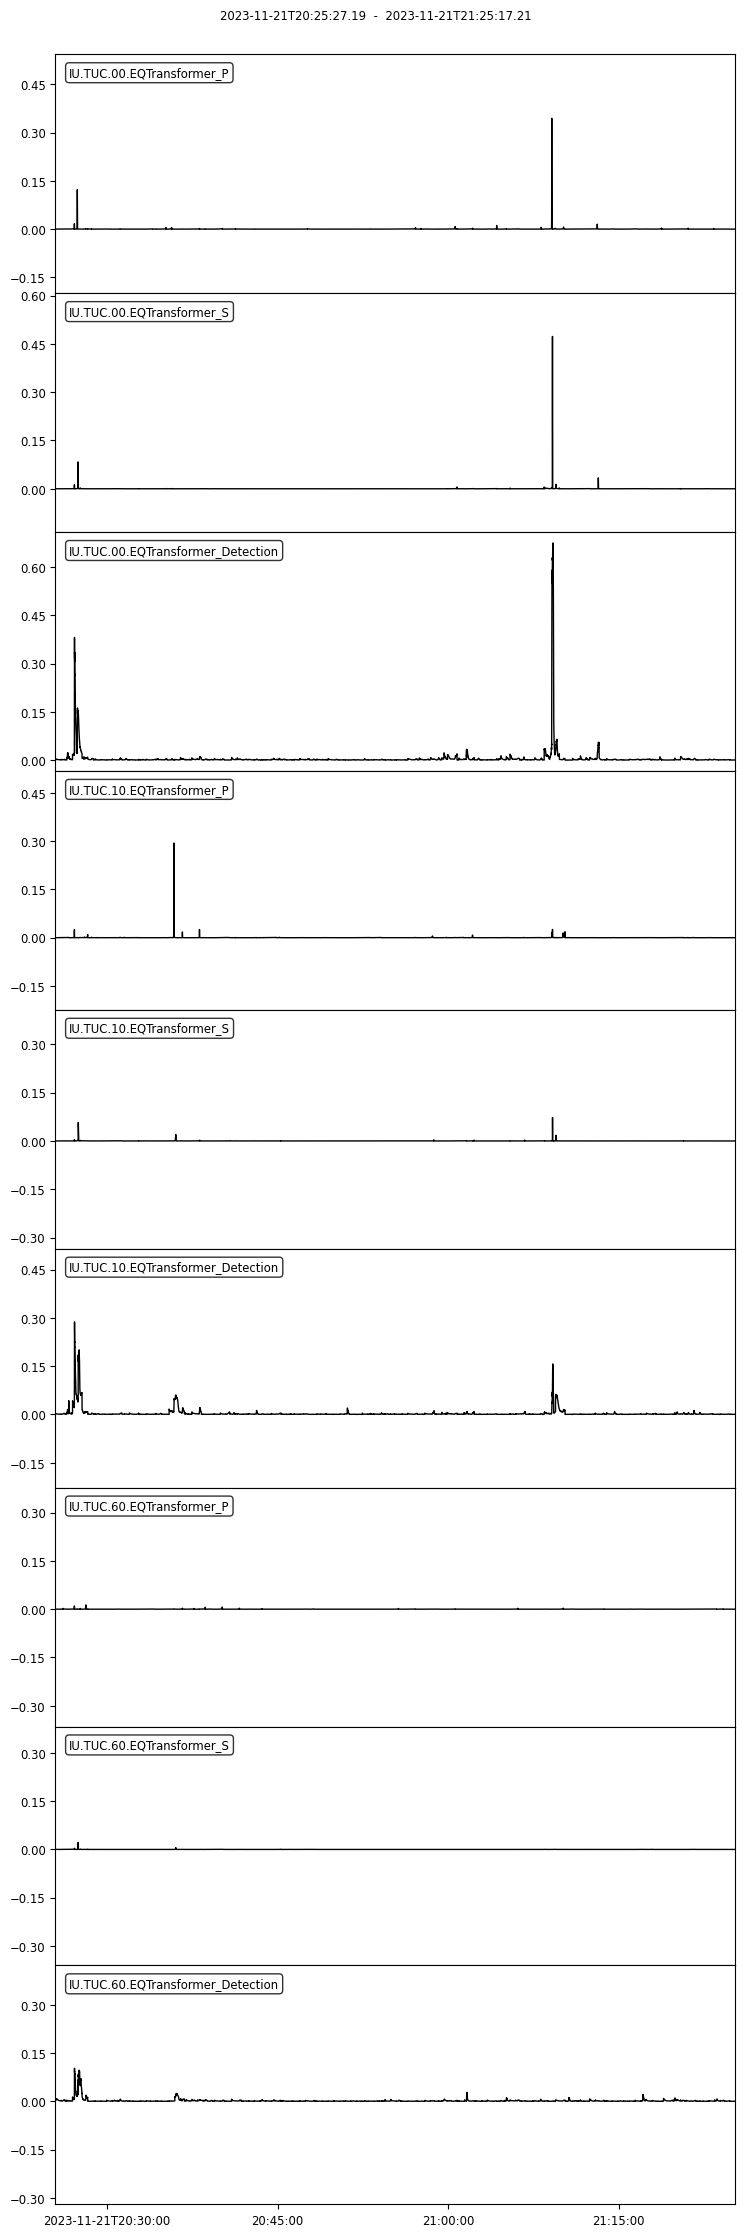

In [391]:
picker.annotate(annotations).plot();

Let's try the other pickers.

In [ ]:
pn_preds = pn_model.annotate(stream)
eqt_preds = eqt_model.annotate(stream)
gpd_preds = gpd_model.annotate(stream)

pn_preds

/usr/local/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/usr/local/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


9 Trace(s) in Stream:
IU.TUC.00.PhaseNet_P | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.00.PhaseNet_S | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.00.PhaseNet_N | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.10.PhaseNet_P | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.10.PhaseNet_S | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.10.PhaseNet_N | 2023-11-21T20:25:24.690000Z - 2023-11-21T21:25:19.680000Z | 100.0 Hz, 359500 samples
IU.TUC.60.PhaseNet_P | 2023-11-21T20:25:24.720000Z - 2023-11-21T21:25:19.710000Z | 100.0 Hz, 359500 samples
IU.TUC.60.PhaseNet_S | 2023-11-21T20:25:24.720000Z - 2023-11-21T21:25:19.710000Z | 100.0 Hz, 359500 samples
IU.TUC.60.PhaseNet_N | 2023-11-21T20:25:24.720000Z - 2023-11-21T21:25:19.710000Z | 100.0 Hz, 359500 samples

In [ ]:
wlength = 5 * 60 #@param

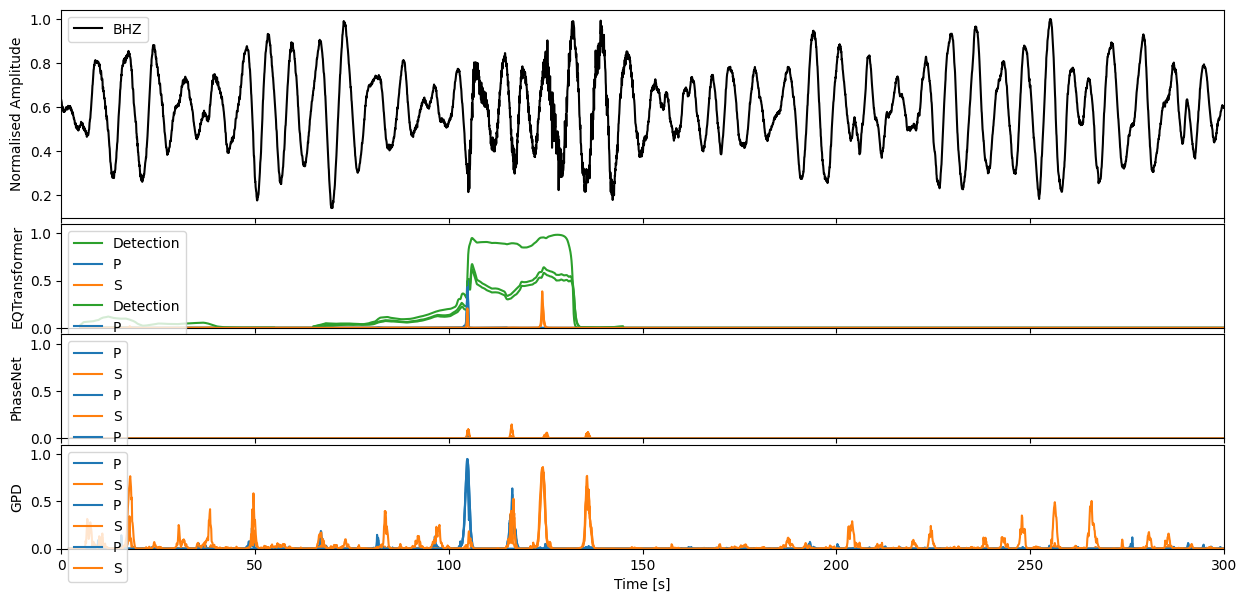

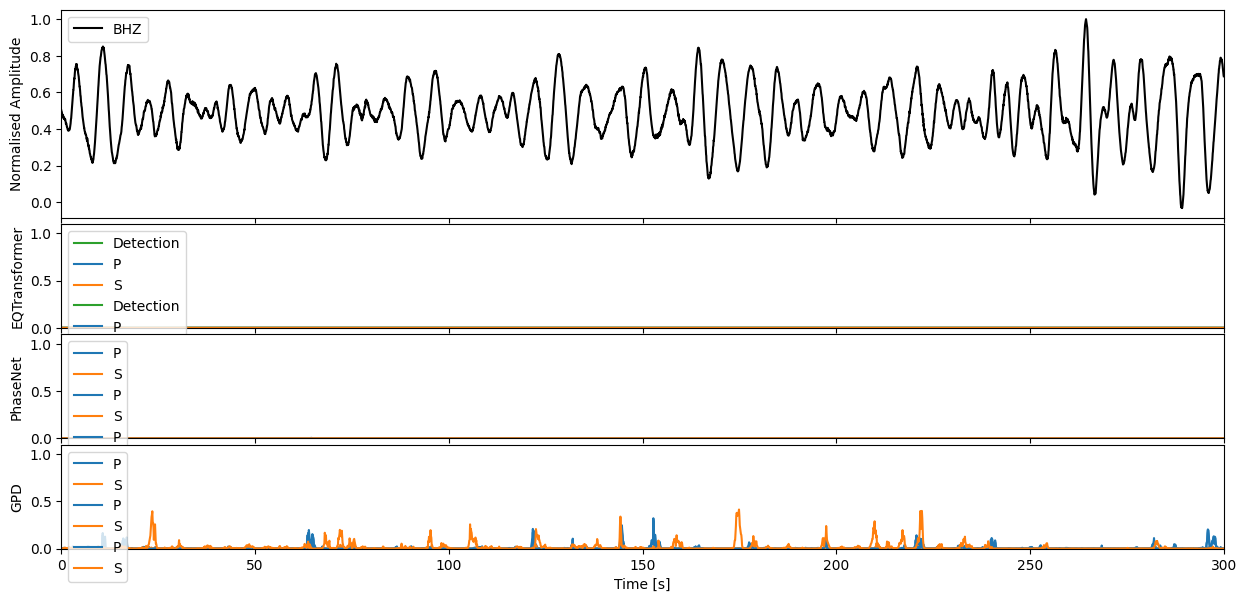

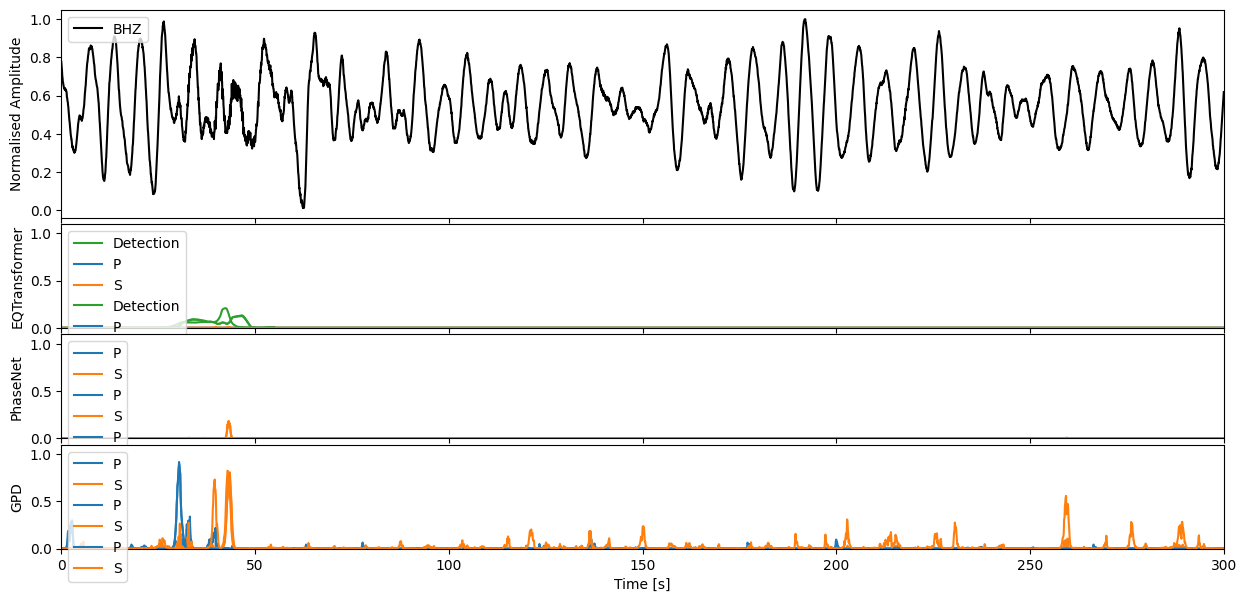

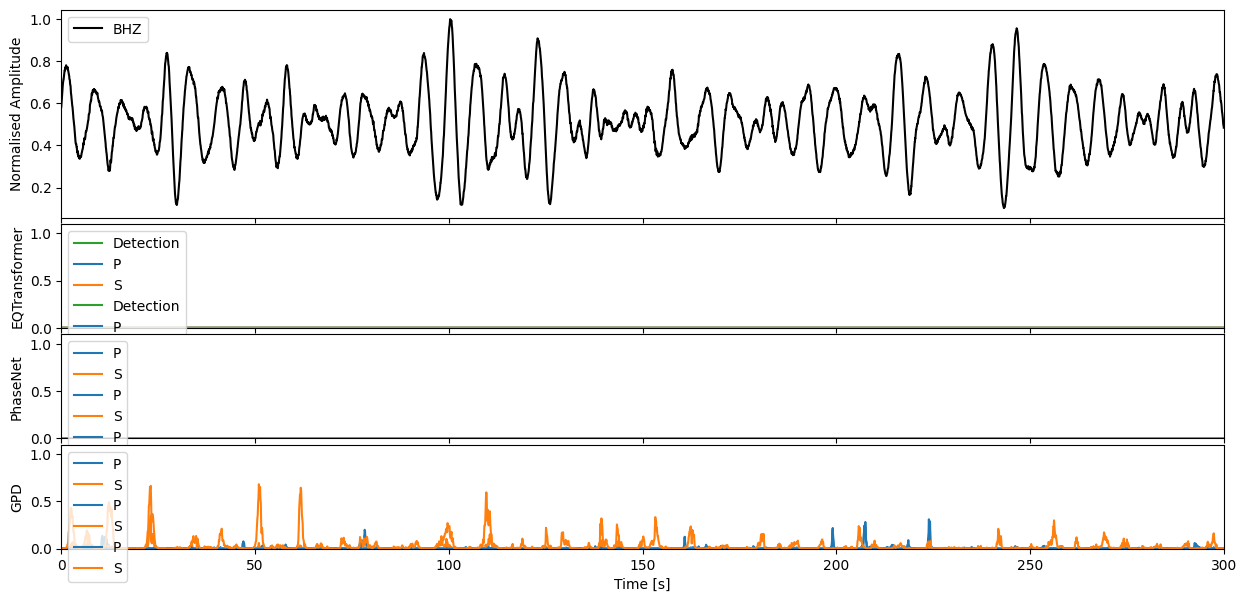

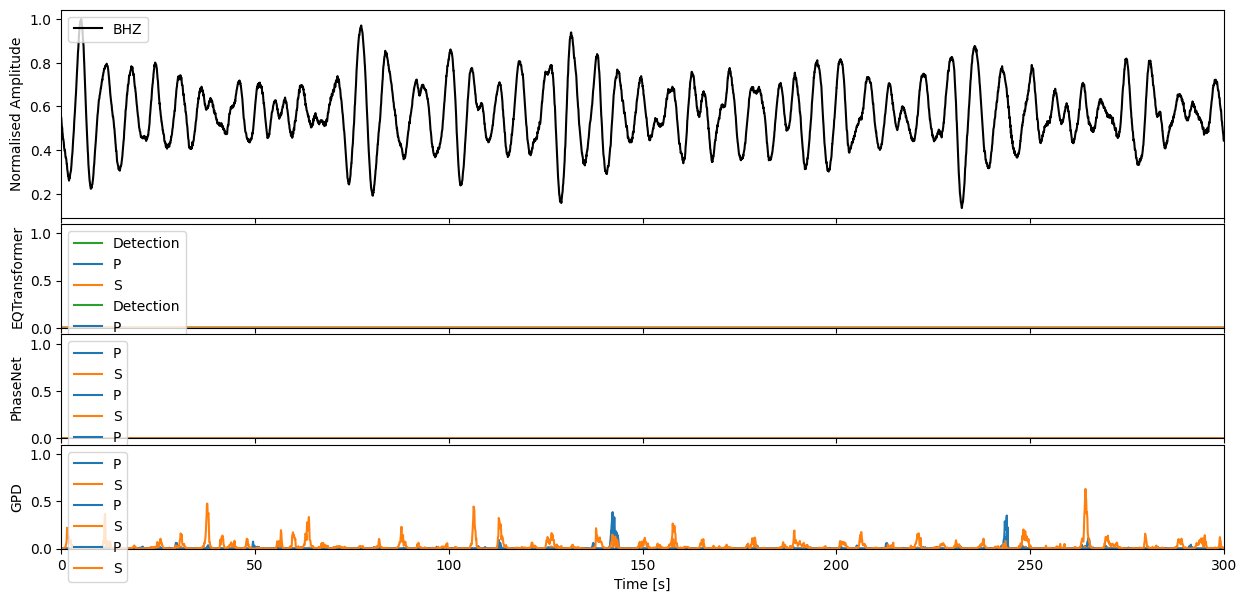

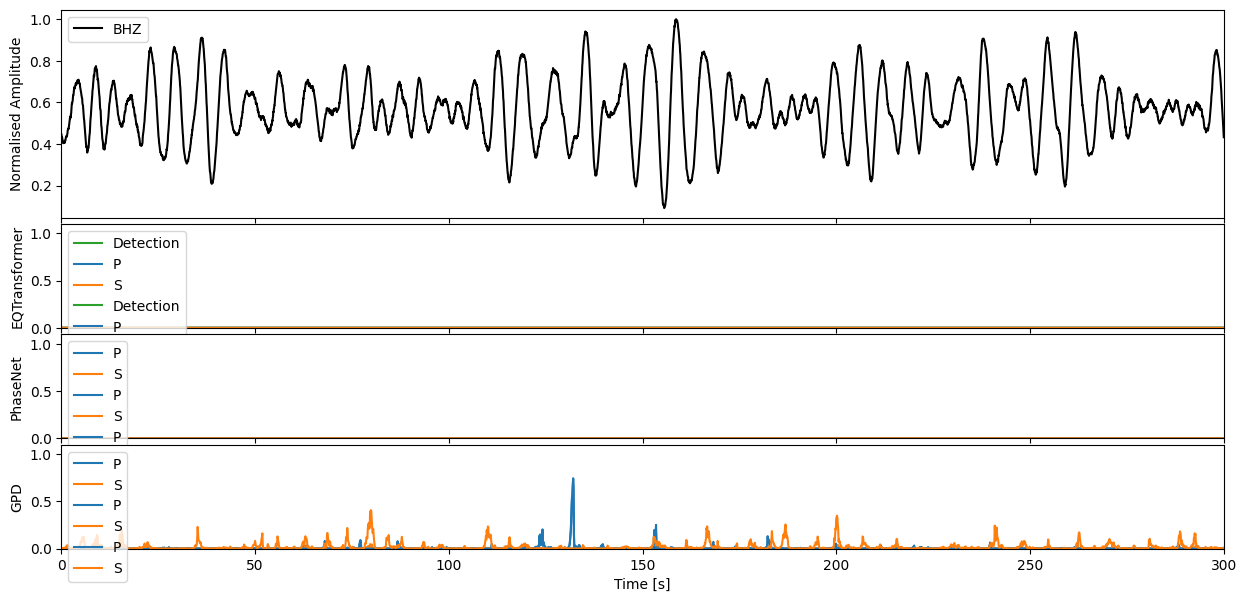

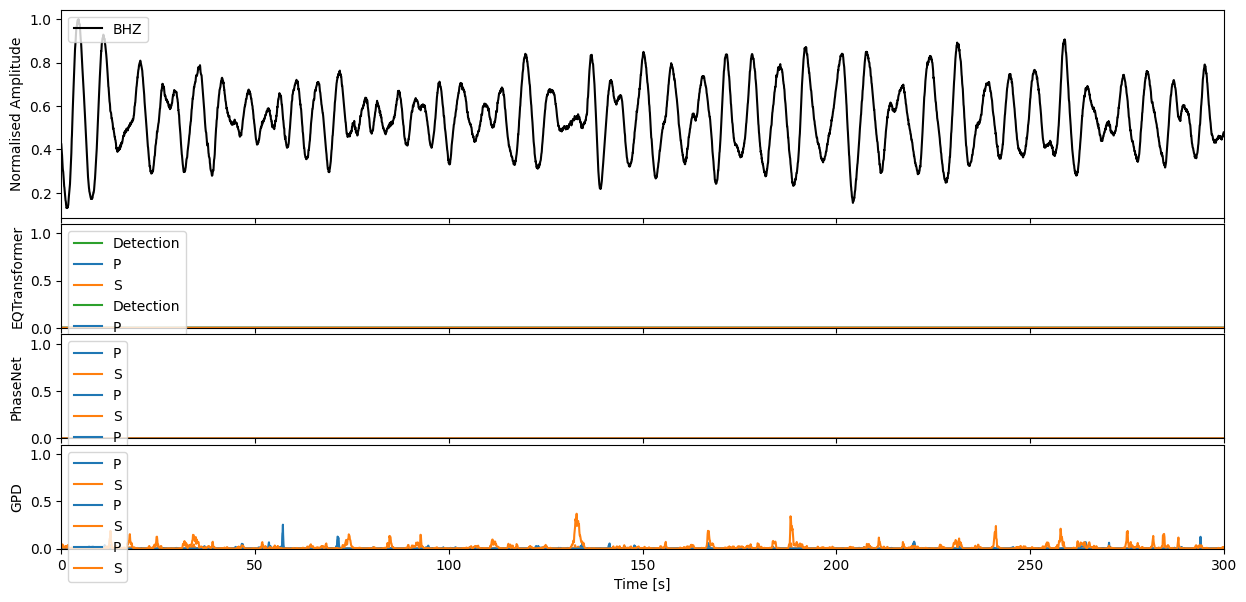

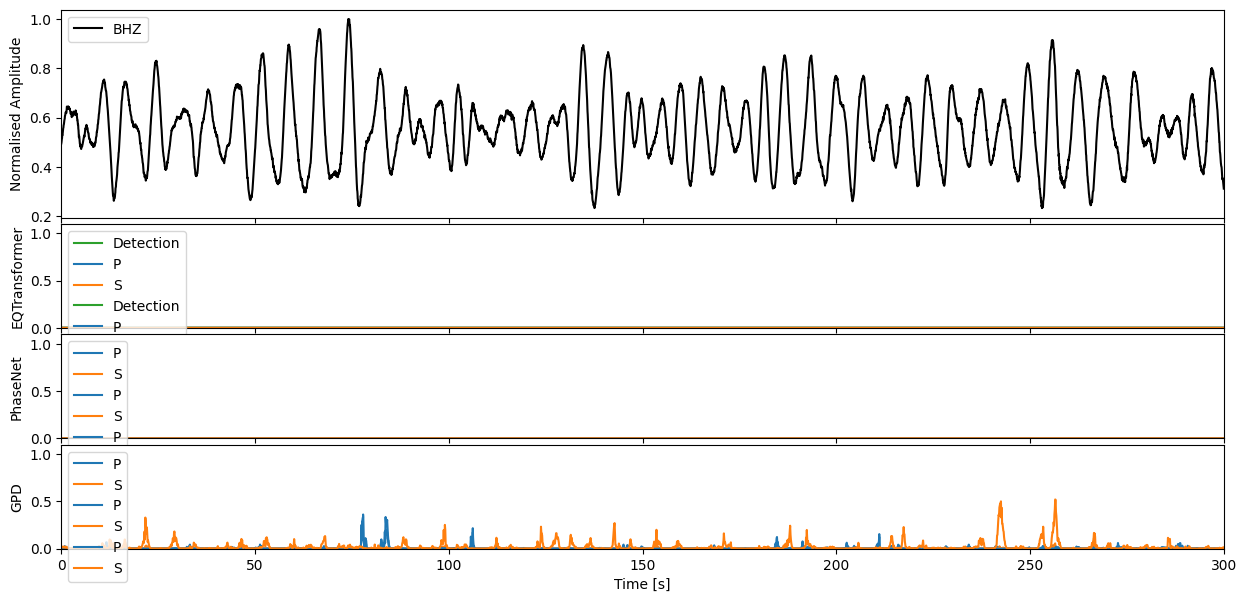

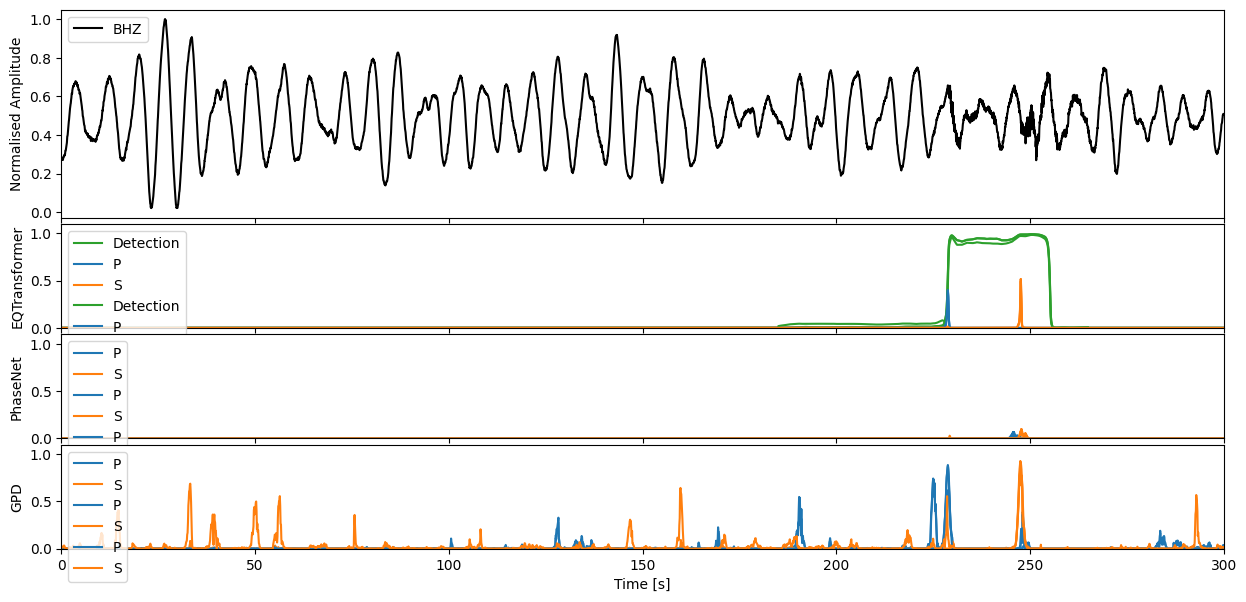

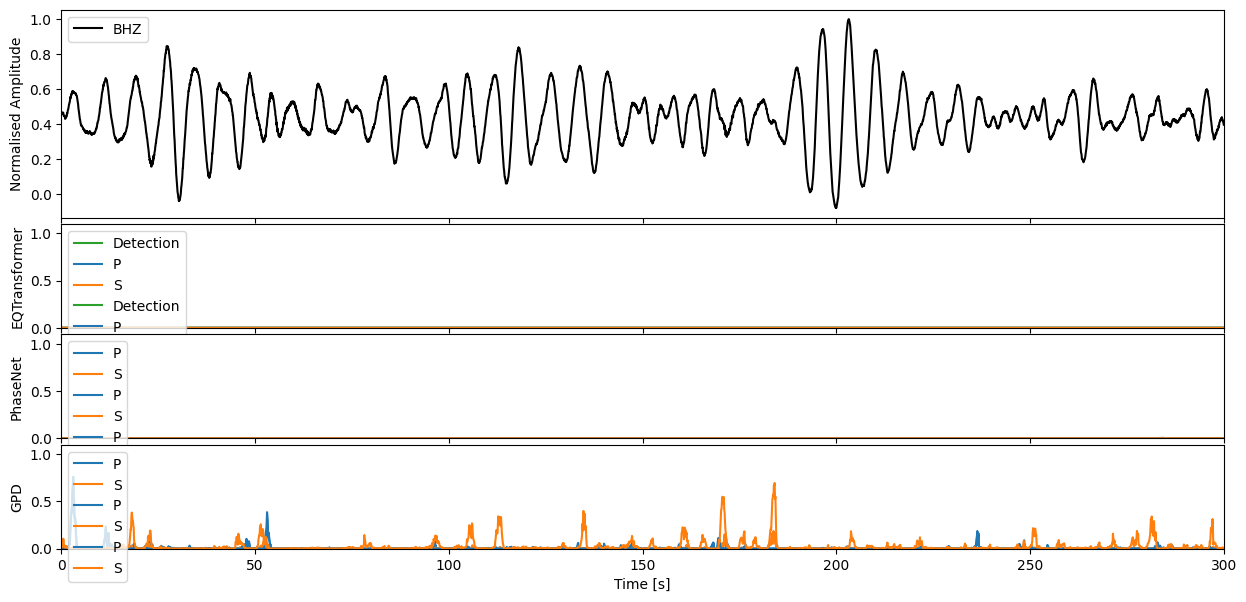

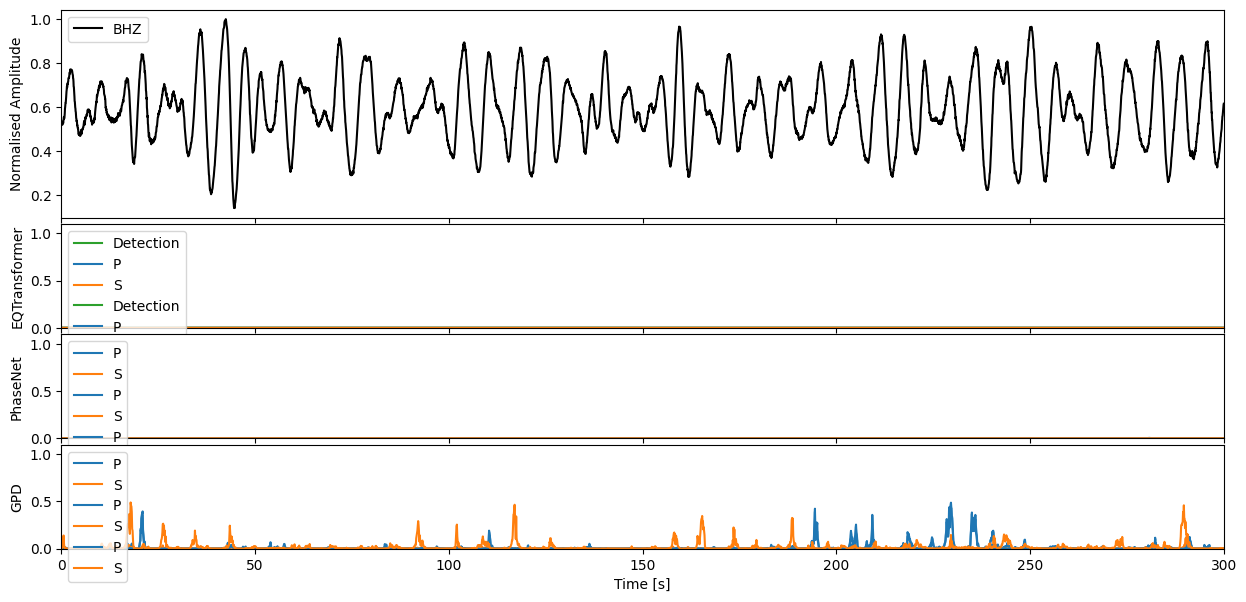

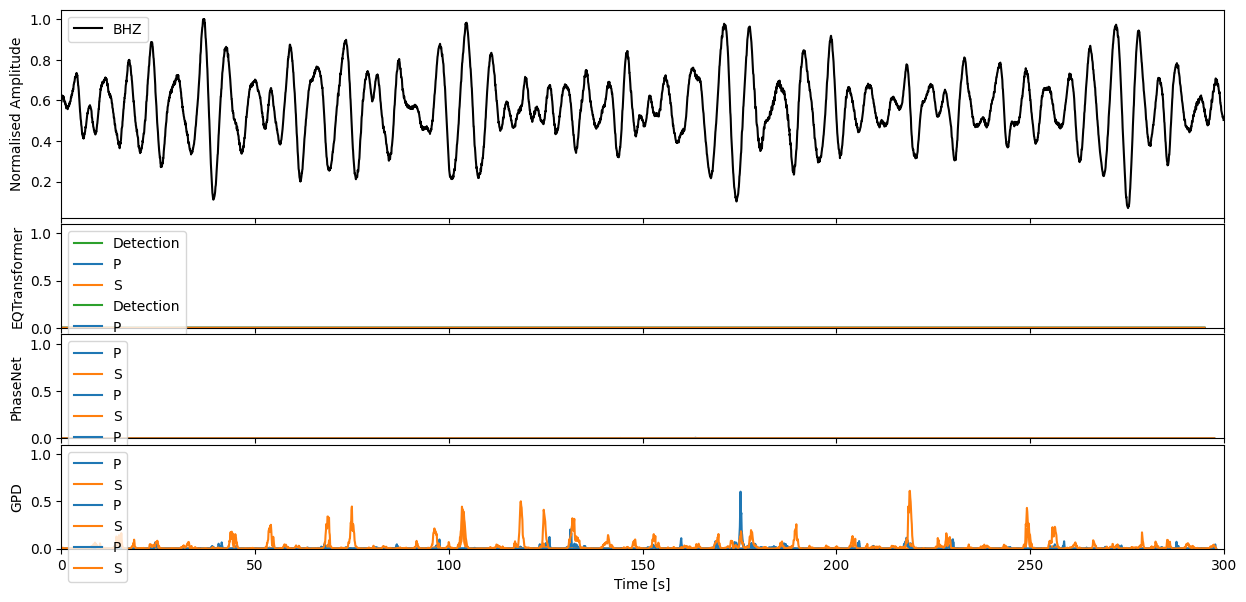

In [ ]:


color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}

for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.slice(t0, t1)

    fig, ax = plt.subplots(4, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1, 1]})

    for i, preds in enumerate([eqt_preds, pn_preds, gpd_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                # Skip noise traces
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(model)
        ax[i + 1].legend(loc=2)
        ax[i + 1].set_ylim(0, 1.1)

    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[3].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.show()

In [ ]:
outputs = pn_model.classify(stream)

In [ ]:
print(outputs)

ClassifyOutput(creator='PhaseNet', picks=PickList with 0 entries:

)
